# **Project Background**

In e-commerce opeartional, data is a powerful asset to have that can be used to understand customer behavior, improve sales strategies, and enhance overall business performance. The dataset used is a dummy dataset generated to simulate various aspects of e-commerce platform. This case study is going to be analyzed using Google's 6 Steps of the Data Analysis Process:
1. Ask
2. Prepare
3. Process
4. Analyze
5. Share
6. Act

## **1. Ask**

What we will do in this analysis:

1. Identify different product segments based on their demographic and behavioral characteristics.
2. Develop targeted marketing strategies for different product segments.

## **2. Prepare**

The data is provided through [Kaggle](https://www.kaggle.com/datasets/muhammadroshaanriaz/e-commerce-trends-a-guide-to-leveraging-dataset) and contains 11 columns. Detailed information about each column is provided below:

1. `ProductID` (numeric)
2. `ProductName` (object)
3. `Category` (object)
4. `Price` (numeric)
5. `Rating` (numeric)
6. `NumReviews` (numeric)
7. `StockQuantity` (numeric)
8. `Discount` (numeric)
9. `Sales` (numeric)
10. `DateAdded` (object)
11. `City` (object)

## **3. Process**
To answer all the questions, firstly, we need to clean the data.

In [71]:
# Import the libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as stats
import folium
import geopandas as gpd

from matplotlib.ticker import FuncFormatter
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from folium.plugins import MarkerCluster
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# Silence the warnings
import warnings
warnings.filterwarnings('ignore')

Now, import the dataset.

In [25]:
df = pd.read_csv('ecommerce_product_dataset.csv')

df.head()

,ProductID,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,City
0,1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-10,Albuquerque
1,2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-28,Queens
2,3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,2023-10-20,Austin
3,4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,2023-12-05,Dallas
4,5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,2023-08-10,Tucson


Check the data types for all columns.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ProductID      1000 non-null   int64  
 1   ProductName    1000 non-null   object 
 2   Category       1000 non-null   object 
 3   Price          1000 non-null   float64
 4   Rating         1000 non-null   float64
 5   NumReviews     1000 non-null   int64  
 6   StockQuantity  1000 non-null   int64  
 7   Discount       1000 non-null   float64
 8   Sales          1000 non-null   int64  
 9   DateAdded      1000 non-null   object 
 10  City           1000 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 86.1+ KB


Several changes can be made into the data types to ease out the EDA:

- Change the `DateAdded` into datetime64.
- Change the `DateAdded`, `ProductID`, `ProductName`, `Category`, and `City` into category since it usually more-memory efficient than the object data type.


Also, there is no identified null missing values in the dataset. However, it should still be checked for duplicates.

In [27]:
# Function to convert data as datetime64[ns]
def convert_dates(date_series):
    formats = ['%d/%m/%Y', '%d-%m-%Y', '%m/%d/%Y', '%Y-%m-%d']

    for fmt in formats:
        try:
            return pd.to_datetime(date_series, format=fmt)
        except ValueError:
            continue
    raise ValueError("Date format not recognized")

# Convert and extract from DateAdded
df['DateAdded'] = df['DateAdded'].apply(lambda x: convert_dates(x))
df['Day'] = df['DateAdded'].dt.day_name().astype('category')
df['Month'] = df['DateAdded'].dt.month_name().astype('category')

# Convert object variable to category to preserve memory usage
df['ProductID'] = df['ProductID'].astype('category')
df['ProductName'] = df['ProductName'].astype('category')
df['Category'] = df['Category'].astype('category')
df['City'] = df['City'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ProductID      1000 non-null   category      
 1   ProductName    1000 non-null   category      
 2   Category       1000 non-null   category      
 3   Price          1000 non-null   float64       
 4   Rating         1000 non-null   float64       
 5   NumReviews     1000 non-null   int64         
 6   StockQuantity  1000 non-null   int64         
 7   Discount       1000 non-null   float64       
 8   Sales          1000 non-null   int64         
 9   DateAdded      1000 non-null   datetime64[ns]
 10  City           1000 non-null   category      
 11  Day            1000 non-null   category      
 12  Month          1000 non-null   category      
dtypes: category(6), datetime64[ns](1), float64(3), int64(3)
memory usage: 112.9 KB


In [28]:
df.duplicated().sum()

0

Now, we should rearrange the days or months extracted in order.

In [29]:
day_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day'] = pd.Categorical(df['Day'], categories=day_ordered, ordered=True)

month_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_ordered, ordered=True)

As there are no duplicates in the dataset, we can proceed. However, before we proceed, we should make a new column/feature for Total Revenue of each product.

In [30]:
df['Revenue'] = (df['Sales'] * (df['Price'] - (df['Price'] * df['Discount'])))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ProductID      1000 non-null   category      
 1   ProductName    1000 non-null   category      
 2   Category       1000 non-null   category      
 3   Price          1000 non-null   float64       
 4   Rating         1000 non-null   float64       
 5   NumReviews     1000 non-null   int64         
 6   StockQuantity  1000 non-null   int64         
 7   Discount       1000 non-null   float64       
 8   Sales          1000 non-null   int64         
 9   DateAdded      1000 non-null   datetime64[ns]
 10  City           1000 non-null   category      
 11  Day            1000 non-null   category      
 12  Month          1000 non-null   category      
 13  Revenue        1000 non-null   float64       
dtypes: category(6), datetime64[ns](1), float64(4), int64(3)
memory usage: 120

## **3.1 EDA: Univariate Analysis**

##### **Summary Statistics**

In [31]:
df.describe().round(2)

,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,Revenue
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000,1000.00
mean,253.78,3.03,2498.75,495.40,0.25,1011.04,2023-12-10 16:06:14.400000,194232.58
min,10.11,1.00,3.00,0.00,0.00,0.00,2023-06-14 00:00:00,0.00
25%,133.09,2.10,1201.75,241.75,0.13,502.00,2023-09-09 00:00:00,53611.78
50%,251.31,3.10,2476.00,505.00,0.25,998.00,2023-12-05 12:00:00,142952.44
75%,375.83,4.00,3797.50,743.50,0.38,1540.00,2024-03-09 00:00:00,295546.90
max,499.74,5.00,4994.00,993.00,0.50,1997.00,2024-06-11 00:00:00,758002.49
std,141.40,1.15,1463.24,292.80,0.15,582.11,NaN,172834.76


Observation results:
- **Date Range**: The dataset spans from 14th June 2023 to 11th June 2024.
- **Potential Outliers**: The dataset does not show any sign of outliers. This might be due to the fact that this dataset is generated for educational purposes and is away from error and real-world cases.
- **Distribution**: By observation from this summary statistics, it can be said that this data set has a normal distribution.

Next, we should see the dataset summary statistics of categorical/string columns.

In [32]:
df.describe(include=['object', 'category'])

,ProductID,ProductName,Category,City,Day,Month
count,1000,1000,1000,1000,1000,1000
unique,1000,100,25,101,7,12
top,1,Biography,Art and crafting materials,New York,Thursday,July
freq,1,22,40,17,155,100


Observation results:
- **Products**: There are 100 unique variables and the top product is **Biography**, accounting for 22 transactions.
- **Category**: There are 25 product category and the top category is **Art and crafting materials**, accounting for 40 transactions.
- **City**: There are 101 uniqu cities with transactions and **New York**  has the highest amount of transactions compared to the other cities, accounting for a total of 17 transaction frequncy.

## **3.2 EDA: Distributions**
First, let's see the distribution of all numeric variables using box plots.

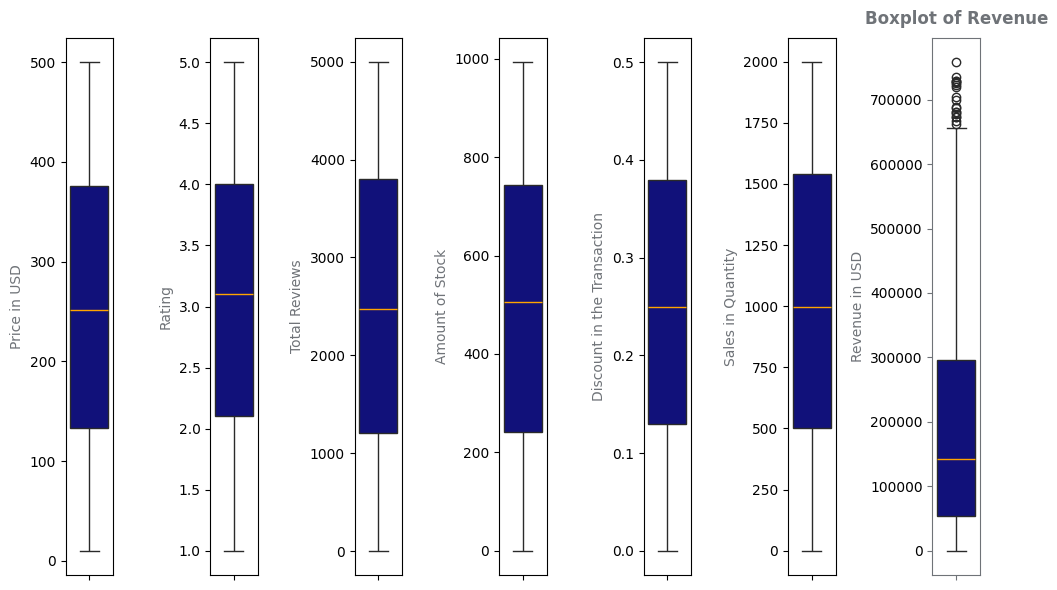

In [33]:
# Get numeric variable
num_var = df.select_dtypes(exclude=['object', 'datetime64[ns]', 'category']).columns.tolist()

# Set the figure and axes
fig, ax = plt.subplots(1, 7, figsize=(10, 6))

# Box plots of numeric columns
for i in range(len(num_var)):

    # Create the box plot
    sns.boxplot(data=df, y=num_var[i], color='darkblue',
                medianprops=dict(color='orange'), ax=ax[i])
    
    if num_var[i] == 'Price':
        ax[i].set_ylabel('Price in USD', color='#6F7378')
    elif num_var[i] == 'Rating':
        ax[i].set_ylabel('Rating', color='#6F7378')
    elif num_var[i] == 'NumReviews':
        ax[i].set_ylabel('Total Reviews', color='#6F7378')
    elif num_var[i] == 'StockQuantity':
        ax[i].set_ylabel('Amount of Stock', color='#6F7378')
    elif num_var[i] == 'Discount':
        ax[i].set_ylabel('Discount in the Transaction', color='#6F7378')
    elif num_var[i] == 'Sales':
        ax[i].set_ylabel('Sales in Quantity', color='#6F7378')
    else:
        ax[i].set_ylabel('Revenue in USD', color='#6F7378')

# Change the tick color
ax[i].tick_params(color='#6F7378')


for spine in ax[i].spines.values():
    spine.set_edgecolor('#6F7378')

ax[i].set_title(f'Boxplot of {num_var[i]}', weight='bold', color='#6F7378', pad=10)

plt.tight_layout()
plt.show()

It can be seen that all of the numeric variable is normally distributed and we can infer the following:
- The common `Price` range falls between approximately $150 and $390.
- The common `Rating` range falls between approximately 2.1 and 4.0 with in the scale of 1 to 5.
- The common `NumReviews` range falls between approximately 1,150 to 3,900 reviews.
- The common `StockQuantity` range fall between approximately 220 to 780.
- The common `Discount` range falls between approximately 0.14 to 0.38.
- The common `Sales` in quantity, range falls between approximately 500 to 1600.
- `Revenue` has global outliers which makes determining the central tendency of price and quantity would be difficult.

Therefore, we need to visualize the distribution of the majority of the data by adjusting the y-axis limit to only focus o the box part.

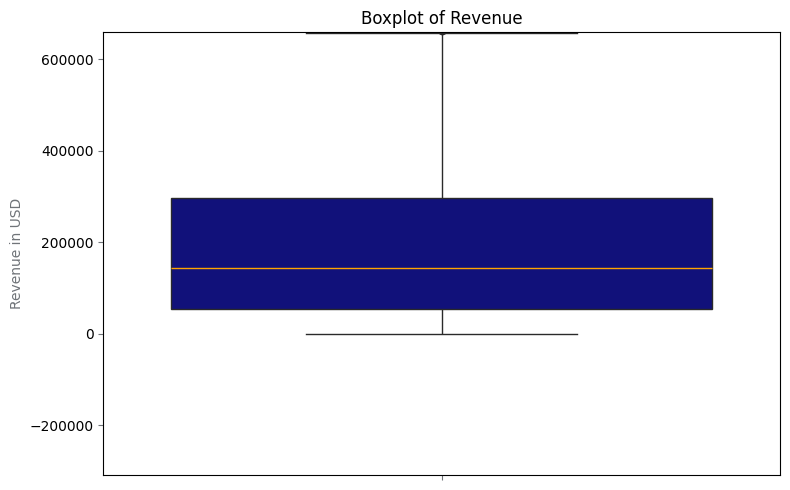

In [34]:
# Set the figure and area
fig, ax = plt.subplots(figsize=(8,5))

# Plot the boxplot
sns.boxplot(data=df, y='Revenue', color='darkblue',
            medianprops=dict(color='orange'))

# Calculate the quartiles
Q1 = df['Revenue'].quantile(0.25)
Q3 = df['Revenue'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the y-axis limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Set the y-axis limit
ax.set_ylim(lower_limit, upper_limit)

# Set the labels, ticks, and title
ax.set_ylabel('Revenue in USD', color='#6F7378')
ax.tick_params(color='#6F7378')
ax.set_title(f'Boxplot of Revenue')

plt.tight_layout()
plt.show()


As the box part of `Revenue` is more visible and feasible to observe, we can determine that:
- The typical `Revenue` is ranging from $50,000 to $300,000.

Now, we should continue the exploration using histogram.

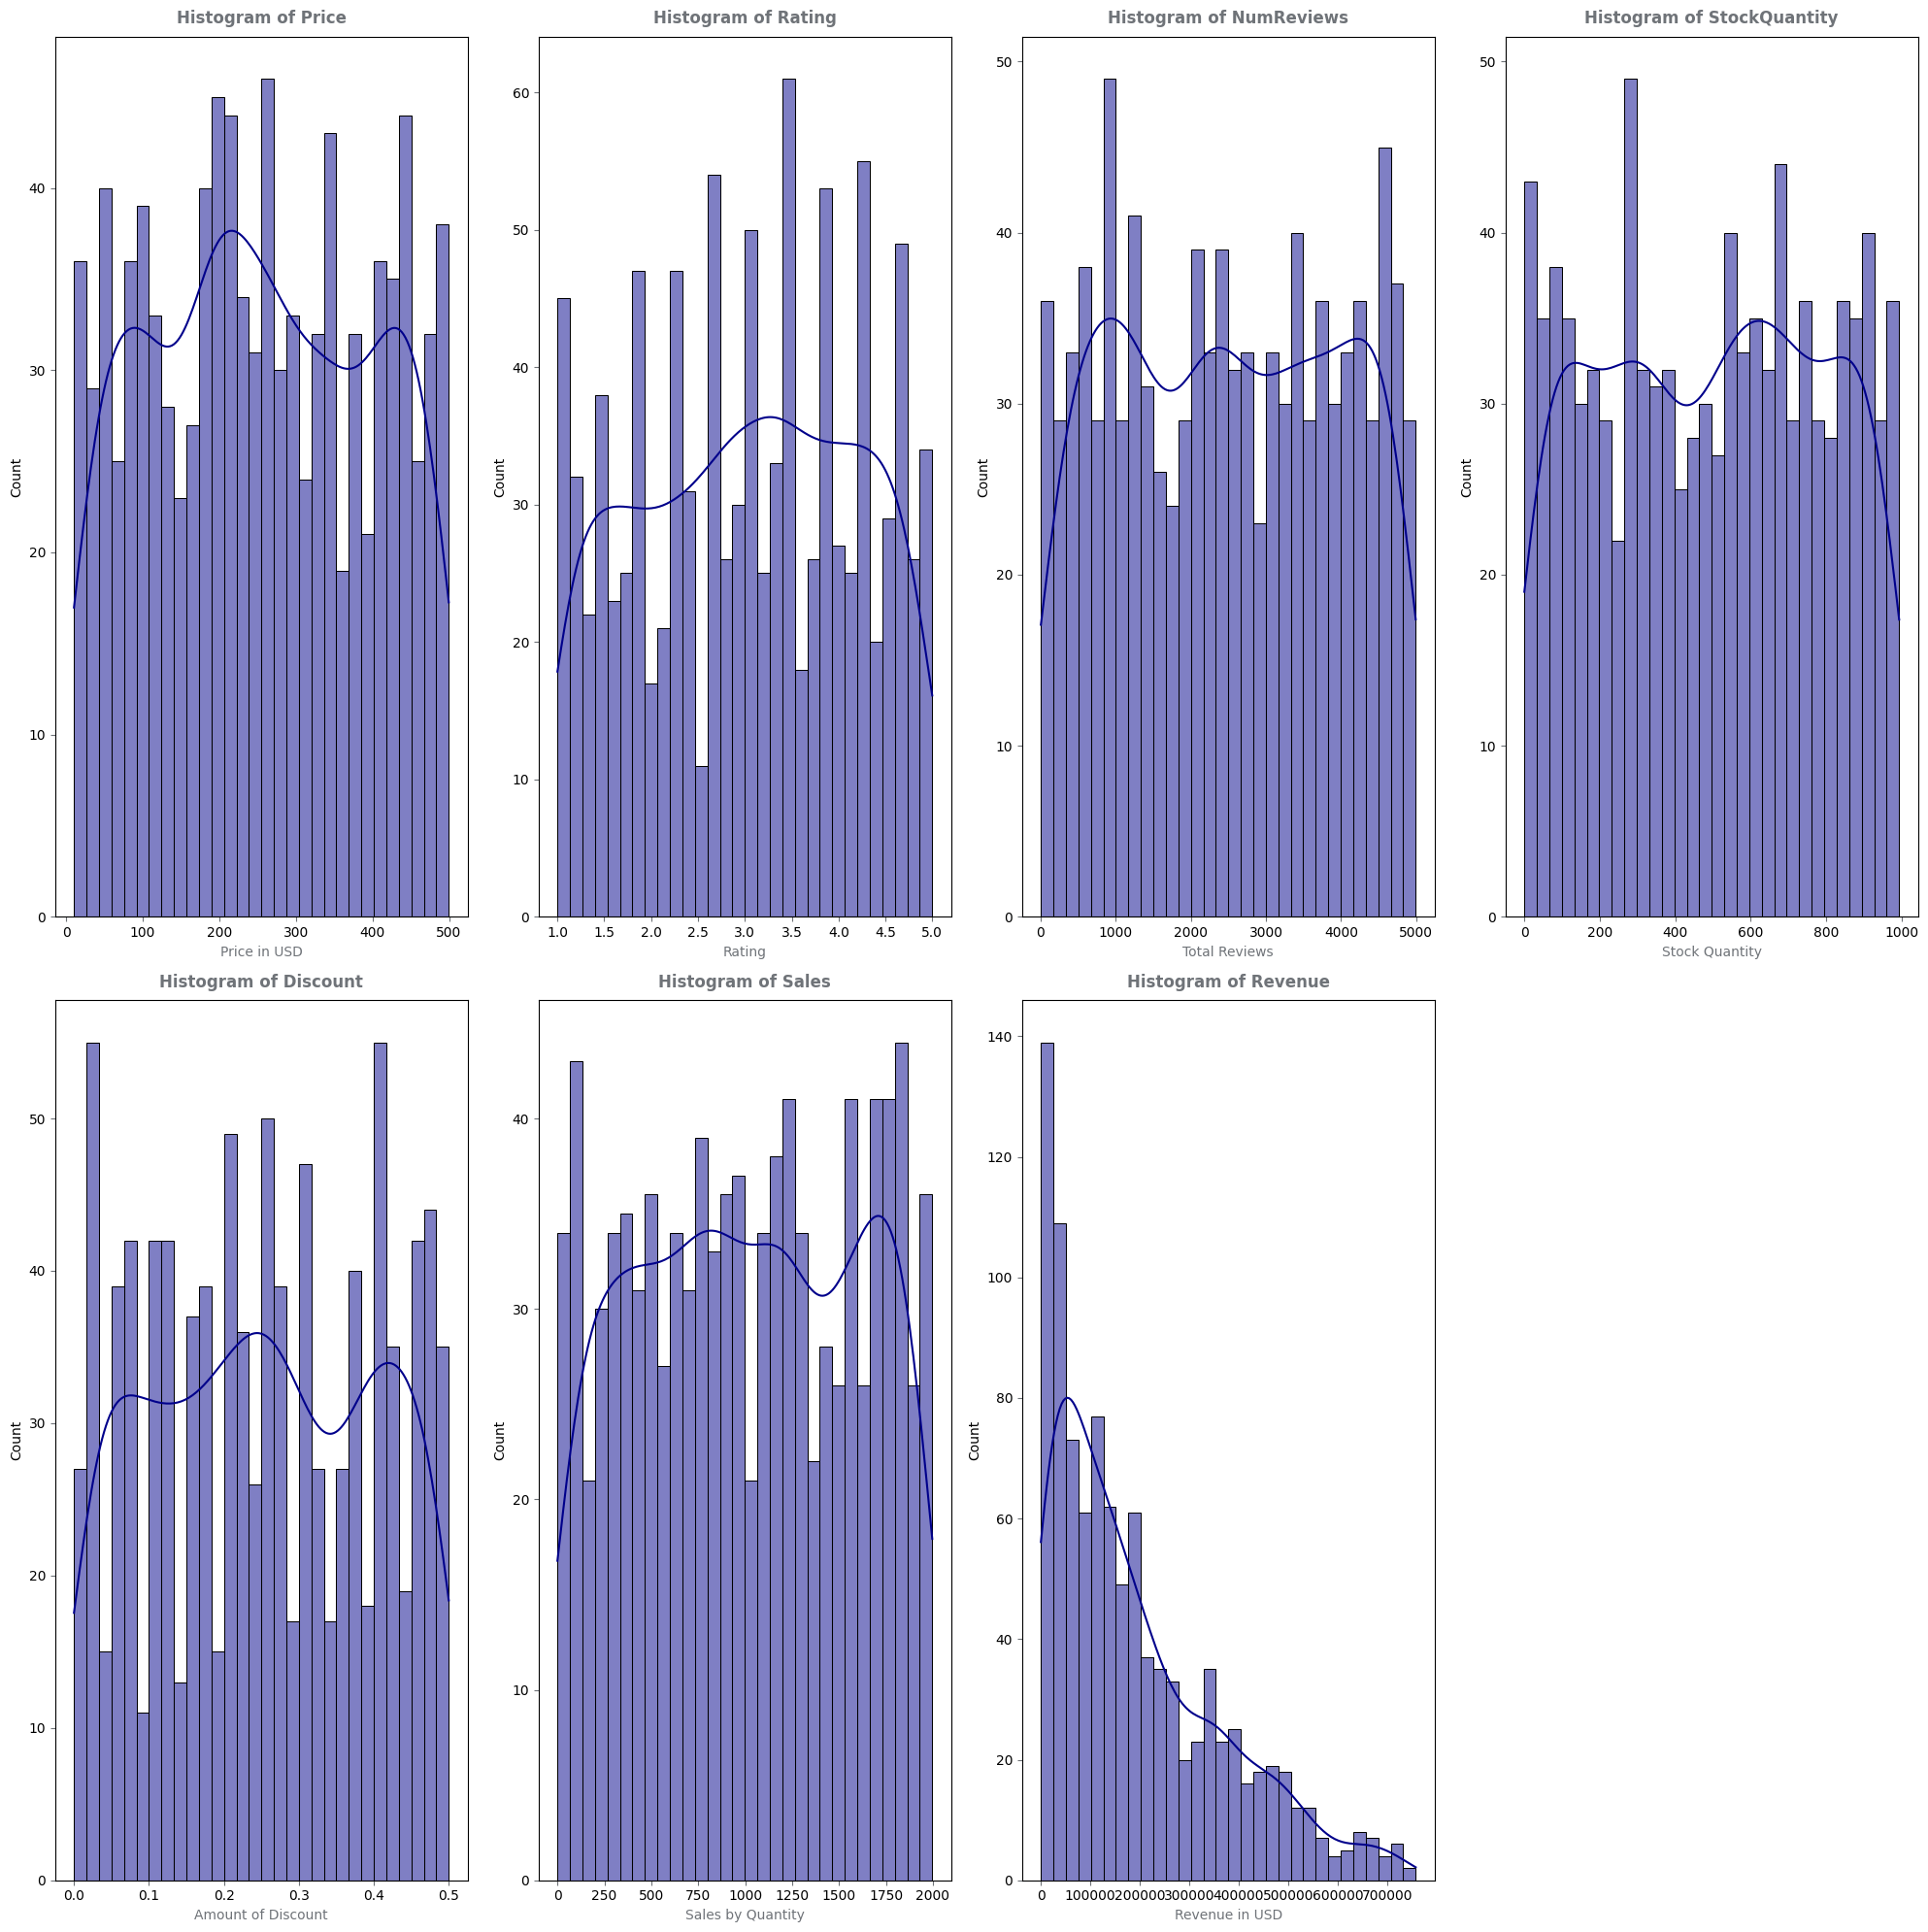

In [35]:
# Set up the plot with Gridspec
fig, ax = plt.subplots(2, 4, figsize=(20, 20), gridspec_kw={'height_ratios': [1, 1]})

# Flattent he ax array for easy iteration
ax = ax.flatten()

for i in range (len(num_var)):

    if num_var[i] == 'Price':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Price in USD', color='#6F7378')

    elif num_var[i] == 'Rating':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True,ax=ax[i])
        ax[i].set_xlabel('Rating', color='#6F7378')
    
    elif num_var[i] == 'NumReviews':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Total Reviews', color='#6F7378')

    elif num_var[i] == 'StockQuantity':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins= 30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Stock Quantity', color='#6F7378')
    
    elif num_var[i] == 'Discount':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Amount of Discount', color='#6F7378')

    elif num_var[i] == 'Sales':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins= 30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Sales by Quantity', color='#6F7378')

    else:
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Revenue in USD', color='#6F7378')

    # Change the tick color
    ax[i].tick_params(color='#6F7378')
    ax[i].set_title(f'Histogram of {num_var[i]}', weight='bold', color='#6F7378', pad=10)

# Remove the empty subplot
fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

Based on the observation of the plot, we can see that not all of the data is distributed normally. The details are:
- **Price**: The distribution appears to be roughly uniform, with mulyiple peaks and valleys. This indicates that the counts are relatively consistent across different price ranges, with no single price range dominating significantly.
- **Rating**: The rating distribution appears to be relatively uniform, with slight peaks and valleys with a tendency for rating counts to be slightly higher in the range of 3.0 to 4.0.
- **Total Reviews**: The distribution is fairly uniform, with several peaks and valleys and no strong skew towards any particular range of total reviews.
- **Stock Quantity**: The stock quantity distribution shows multiple peaks and valleys and the counts are somewhat evenly sprea across different uantities, though htere are noticeable peaks a certain quantities.
- **Amount of Discount**: The discount amount is distributed uniformly with multiple peaks and the counts are relatively consistent across different discount levels, indicating that discounts are spread across a range of values.
- **Sales by Quantity**: The sales quantity are relatively uniform with variety of peaks and valleys. Higher counts are observed to be in the mid-to-upper ranges, which indicates frequent sales at these quantities.
- **Revenue**: The revenue is heavyly positive-skewed. This indicates that lower revenue transactions are more common.

The conclusion are:
- Several variables display a **roughly uniform distribution** with multiple peaks and valleys, which suggest no single value dominates the dataset.
- The **Revenu** is the only variable that shows a skewness with a positive-skewness, which indicate a large number of lower revenue per transaction which dominates the dataset.
- Many variable shows **Peaks and Valleys** which suggest variability in the dataset and possible clustering at certain values.

Based on the conclusion, we should check using the measure of distribution and skewness.


In [36]:
df.skew(numeric_only=True)

Price            0.031605
Rating          -0.078781
NumReviews       0.000140
StockQuantity   -0.022212
Discount         0.000592
Sales           -0.017176
Revenue          1.056348
dtype: float64

Therefore, we can confirm our findings of the numeric variables, with `Revenue` having a high positive-skewness compared to the other numeric variables.

We can continue to our categorical variable. However, we should first examine the number of unique values of each categorical variable has to understand the diversity of the categorical data.

In [37]:
cat_var = df.select_dtypes(include=['category']).columns.to_list()

for i in cat_var:
    display(df[i].value_counts())
    print(f'Unique values: {len(df[i].unique())} \n')

ProductID
1       1
672     1
659     1
660     1
661     1
       ..
339     1
340     1
341     1
342     1
1000    1
Name: count, Length: 1000, dtype: int64

Unique values: 1000 



ProductName
Biography          22
Mountain Bike      19
Throw Blanket      18
Denim Jacket       17
Eau de Toilette    15
                   ..
Rain Jacket         5
Winter Coat         5
Cuticle Oil         5
Pillar Candle       4
Fantasy Book        4
Name: count, Length: 100, dtype: int64

Unique values: 100 



Category
Art and crafting materials    40
Makeup                        40
Vitamins and supplements      40
Underwear                     40
Toys & Games                  40
Socks                         40
Skin care                     40
Posters and artwork           40
Perfume and cologne           40
Nail care                     40
Motor vehicle parts           40
Mobile phone accessories      40
Home & Kitchen                40
Bath and body                 40
Electronics                   40
Drinkware                     40
Cookware                      40
Coats and jackets             40
Clothing                      40
Candles                       40
Books                         40
Blankets                      40
Bicycles                      40
Bedsheets                     40
Wine                          40
Name: count, dtype: int64

Unique values: 25 



City
New York         17
Spokane          17
Palm Bay         17
San Francisco    16
San Jose         15
                 ..
Long Beach        5
Worcester         5
Springfield       4
Nashville         4
Brooklyn          3
Name: count, Length: 101, dtype: int64

Unique values: 101 



Day
Thursday     155
Saturday     148
Monday       144
Sunday       144
Wednesday    142
Tuesday      137
Friday       130
Name: count, dtype: int64

Unique values: 7 



Month
July         100
November      96
August        89
September     86
December      84
October       81
March         80
May           79
April         78
February      77
January       75
June          75
Name: count, dtype: int64

Unique values: 12 



With different amounts of unique values of the categorical variables, we'll use different visualization techniques.
- We can remove `ProductID` since each value of it are unique. However, this can be used as an identifier.
- For `Category`, `ProductName`, and `City`, bar chart which focus on the top N.

Now, we can continue to see the distributions of the categorical variable using a countplot.

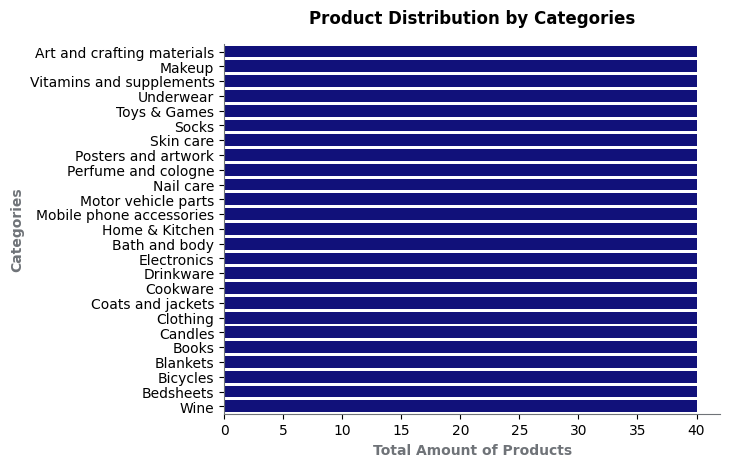

In [38]:
# Set up the figure and axes
fig, ax = plt.subplots()

# Create the countplot
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index,
              color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the labels
ax.set_xlabel('Total Amount of Products', weight='bold', color='#6F7378')
ax.set_ylabel('Categories', weight='bold', color='#6F7378')

# Style the spine
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Product Distribution by Categories', pad=15, weight='bold')

plt.show()

When distributed by the category, sold products are uniformly distributed at 40 products at each categories.

Then, we should see the distribution by top 10 product name.

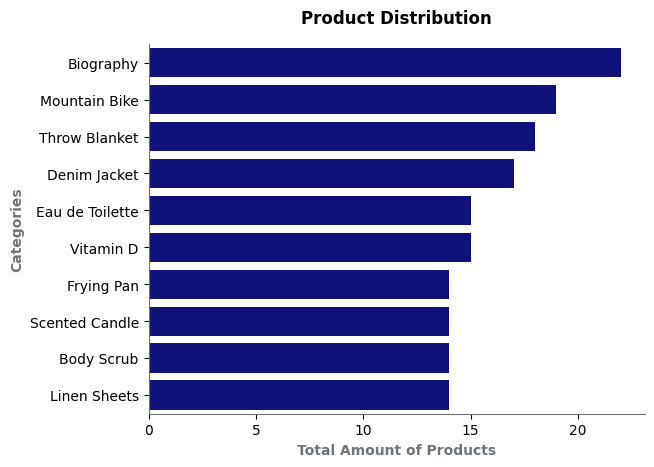

In [39]:
# Set up the figure and axes
fig, ax = plt.subplots()

# Create the countplot
sns.countplot(y=df['ProductName'], order=df['ProductName'].value_counts().iloc[:10].index,
              color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the labels
ax.set_xlabel('Total Amount of Products', weight='bold', color='#6F7378')
ax.set_ylabel('Categories', weight='bold', color='#6F7378')

# Style the spine
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Product Distribution', pad=15, weight='bold')

plt.show()

Based on the plot, we can conclude that our data has a large number of unique variables with over 100 different products sold. Moreover, it is identified that **Biography** has the higest frequency, accounting over 22 transactions. 

Now, let's see the distribution by the city.

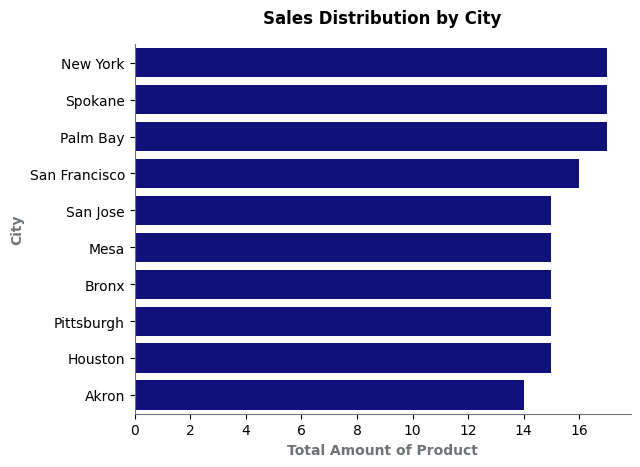

In [40]:
# Set up the figure and axes
fig, ax = plt.subplots()

# Create the countplot
sns.countplot(y=df['City'], order=df['City'].value_counts().iloc[:10].index,
              color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the labels
ax.set_xlabel('Total Amount of Product', weight='bold', color='#6F7378')
ax.set_ylabel('City', weight='bold', color='#6F7378')

# Style the spine
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Sales Distribution by City', pad=15, weight='bold')

plt.show()

Based on the countplot of sales distribution by city, we can infer the following:
- **New York**, **Spokane**, and **Palm Bay** has the highest total amount of products which indicates that these three city are important markets for the e-commerce.
- There is a relatively consistent sales distribution across cities such as, San Jose, Mesa, Bronx, Pittsburgh, and Houston, suggesting a balanced distribution in these locations.

## **3.3 EDA: Bivariate and Multivariate Analysis**
We'll begin our exploration by examining the relationships between numerical variables, which are:
1. `Price`
2. `Rating`
3. `NumReviews`
4. `StockQuantity`
5. `Discount`
6. `Sales`
Therefore, we should investigate the correlation of these variables to assess the strength and direction of linear relationships between these variables.

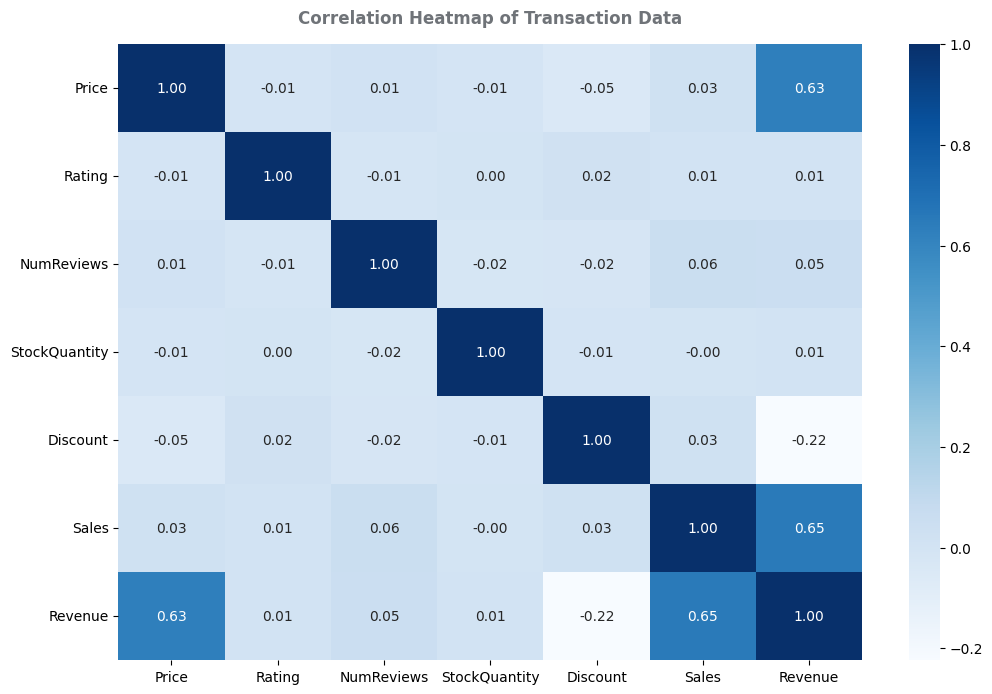

In [41]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(12,8))

# Create the correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues',
            fmt='.2f', ax=ax)

# Add title
ax.set_title('Correlation Heatmap of Transaction Data', pad=15, weight='bold', color='#6F7378')

plt.show()

Based on the correlation heatmap of transaction data, we can infer the following:
- **Price** and **Revenue** has a strong positive correlation with a value of 0.63, indicating that higher prices are associate with higher revenue.
- **Sales** and **Revenue** also show a strong positive correlation with a value of 0.65 which suggest that an increase in sales quantity contributes significantly to revenue growth.
- There is a moderate negative correlation between **Discount** and **Revenue** which implies that a higher discount rate may lead to a lower revenue by reducing the profit margins.
- For the other variables, there are no strong linear relationships among them.

We should continue by checking the relationship between numerical data using a pair plot.

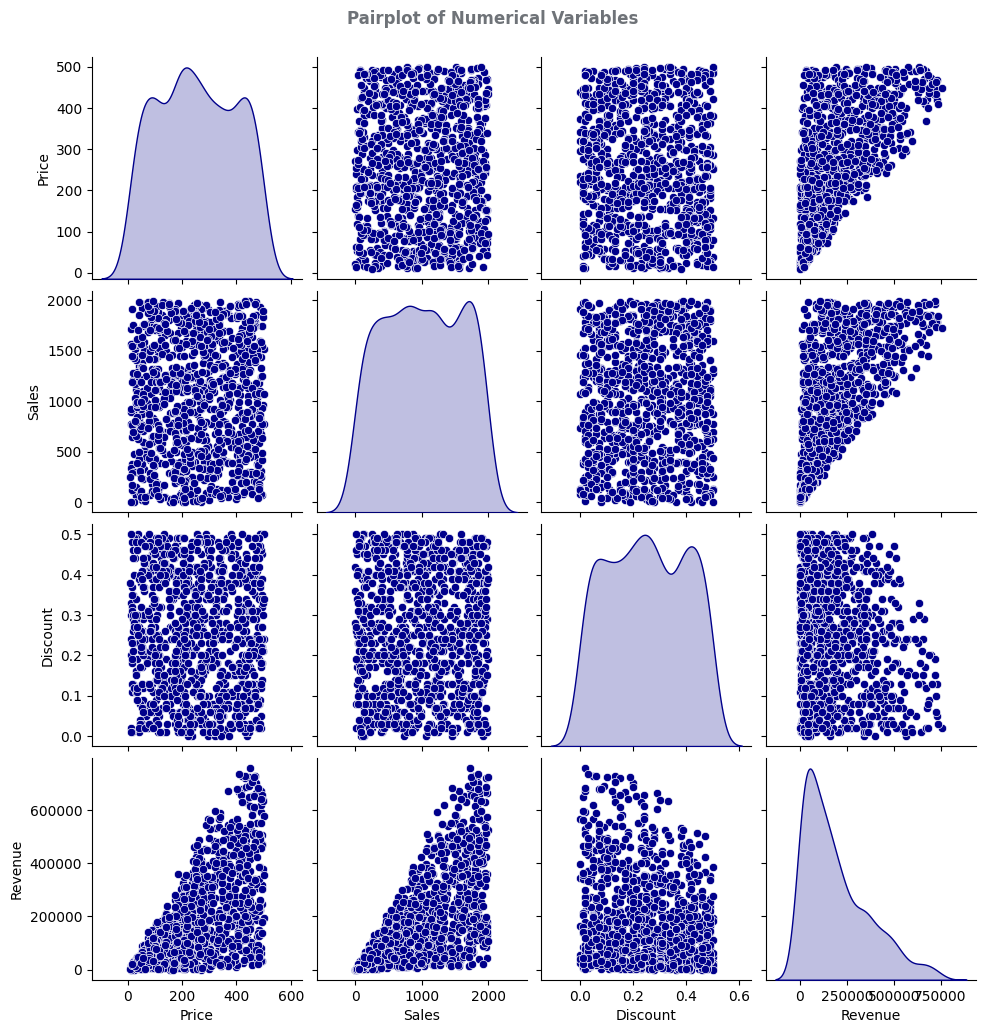

In [42]:
# Create the pair plot
sns.pairplot(df[['Price', 'Sales', 'Discount', 'Revenue']], diag_kind='kde',
             plot_kws=dict(color='darkblue'), diag_kws=dict(color='darkblue'))

# Add the title
plt.suptitle('Pairplot of Numerical Variables', weight='bold', color='#6F7378', y=1.03)

plt.show()

Based on the pair plot, we can conclude the following:
- We can see from the plot that both **Price** and **Sales** has a significant impact on **Revenue** with a clear positive relationship.
- However, the relationship between **Price** and **Sales** is not strongly linear, suggesting that the quantity of sales does not directly depend on the price alone. Other factors might be affecting sales quantities, such as product category, market demand, or promotions.
- Consistent with the correlation heatmap, the relationship between **Discount** and **Revenue** shows a negative linear characteristics. As higher discount is added into the transaction, there would be less revenue.

#### **Transaction Sales Performance**
Next, we are going to analyze the temporal aspects of transactions by analyzing the performance of `Revenue` over time. Since `Revenue` was calculated from `Price`, `Quantity`, and `Discount`, it comprehensively represents sales performance and transaction patterns.

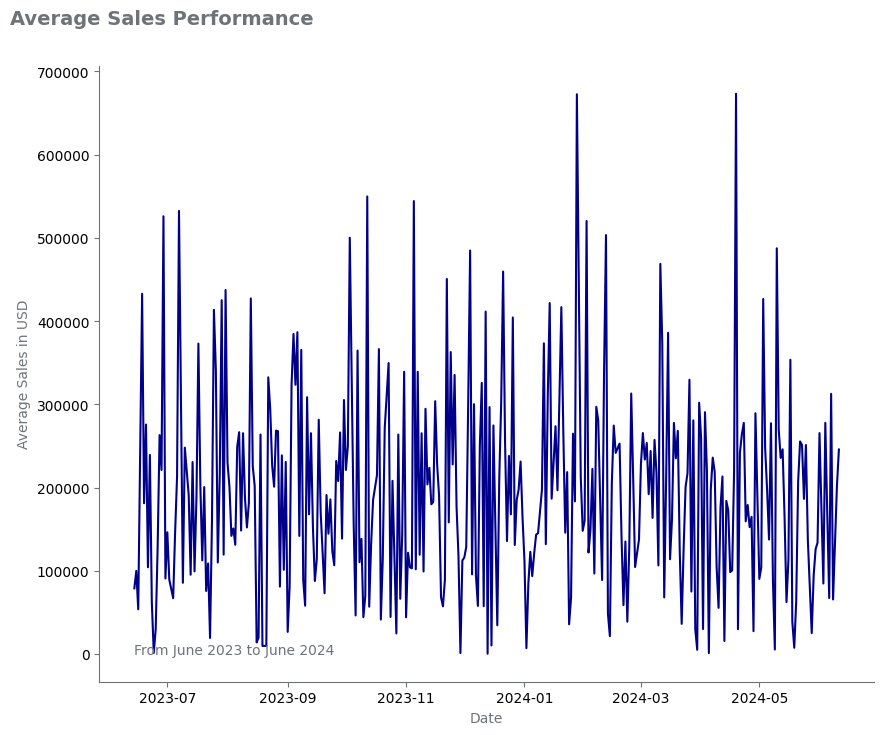

In [43]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot the sales trend across the date
sns.lineplot(x='DateAdded', y='Revenue', data=df, ci=None, color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the label
ax.set_xlabel('Date', color='#6F7378')
ax.set_ylabel('Average Sales in USD', color='#6F7478')

# Change the spine color
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Set the title
ax.set_title('Average Sales Performance', weight='bold', pad=30, size=14, x=-0.115,
             color='#6F7378', ha='left')
ax.text(s='From June 2023 to June 2024', x=pd.Timestamp('2023-06-14'), y=360, color='#6F7378' )

# Change tick color
ax.tick_params(color='#6F7378')

plt.show()

Based on the plot, we can see that the sales performance is highly volatile, with significant fluctuations in average sales on a day-to-day basis with several peaks and troughs throughout the year, suggesting possible seasonal effects. There are high peaks visible in the grap, notably around late 2023 and early 2024 and noticeable periods where sales dip significantly. Moreover, the graph exhibits short-term volatility, with sales figure rapidly rising and falling which could be due to various factors like market demand fluctuations, stock availability, pricing strategies, or external economic conditions.

Next, step is to see the monthly and daily sales trends for a more detailed analysis.


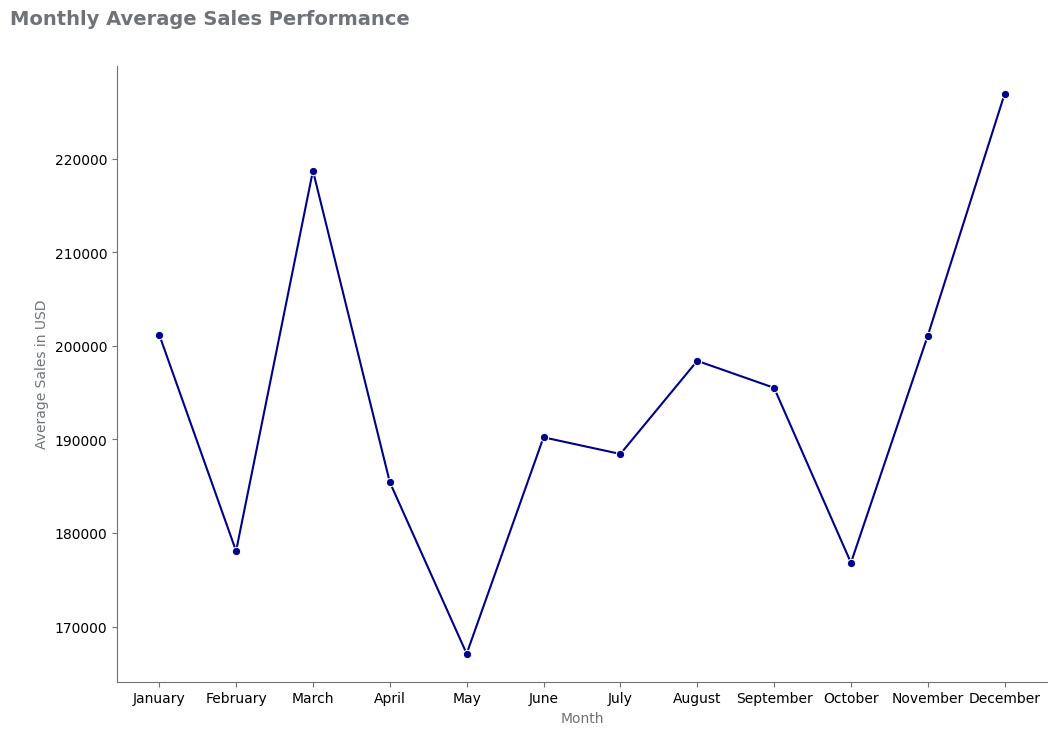

In [44]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(12,8))

# Plot the sales trend across the date
sns.lineplot(x='Month', y='Revenue', data=df, ci=None, marker='o', color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the label
ax.set_xlabel('Month', color='#6F7378')
ax.set_ylabel('Average Sales in USD', color='#6F7478')

# Change the spine color
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Set the title
ax.set_title('Monthly Average Sales Performance', weight='bold', pad=30, size=14, x=-0.115,
             color='#6F7378', ha='left')

# Change tick color
ax.tick_params(color='#6F7378')

plt.show()

When analyzed for its monthly sales. We can see that there is a seasonal pattern and changes in the monthly sales. There are several patterns from this plot which can be pointed out:
1. **Sales Fluctuation**
    - *High Points*: Sales peak in March, August, and December suggesting an increase in sales.
    - *Low Points*: Sales dip in Feburary, May, and October suggesting a decrease in sales.
2. **Seasonal Influence**
    - *March and December Peaks* might be influenced by end-of-quarter sales in March and holiday season sales in December.
    - *August Peak* might be related to summer promotions or increased consumer spending during the holiday season.

To better understand the sales trend, we can examine the average price and quantity across all months.

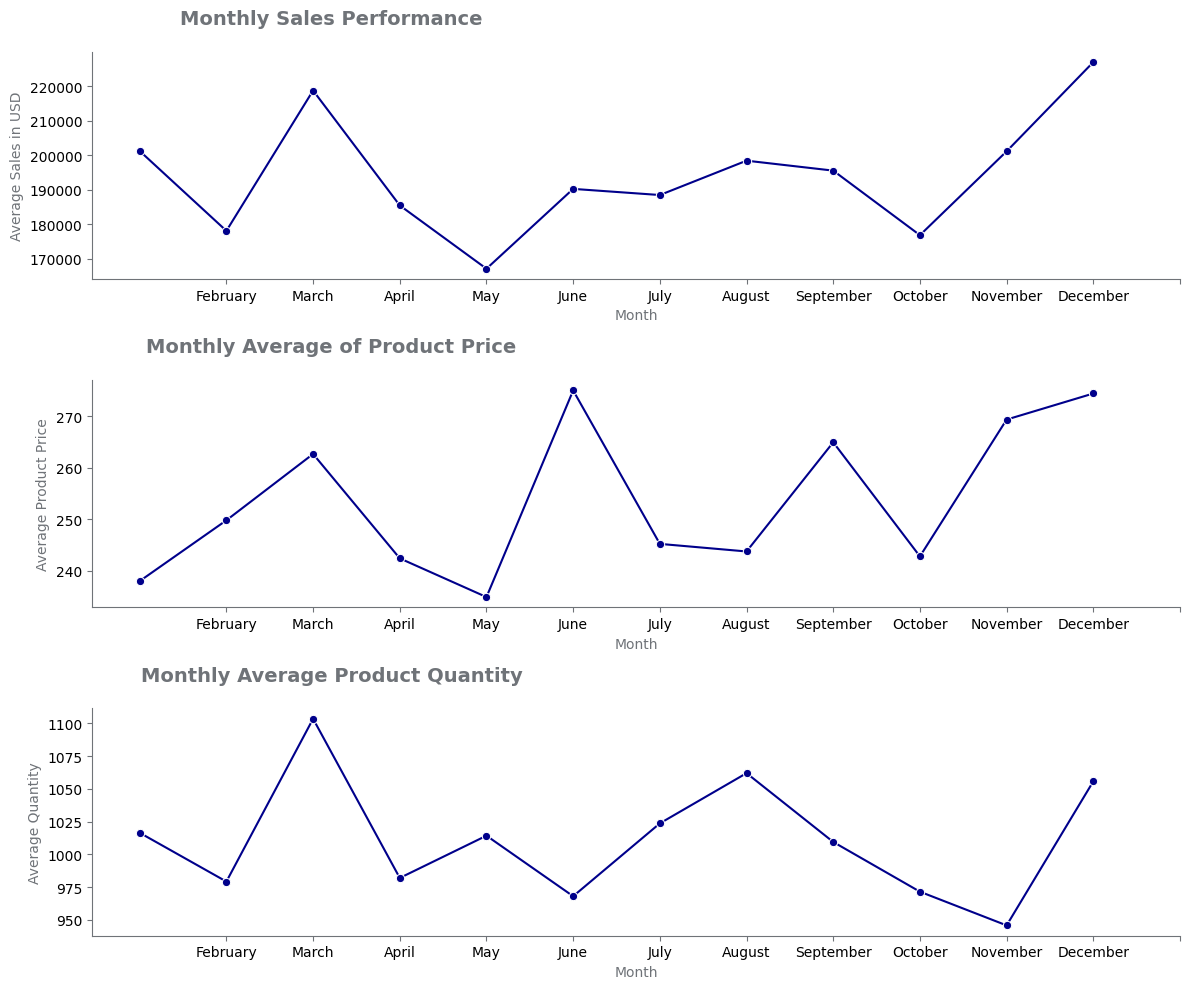

In [45]:
# Get the list of Price and Sales(Quantity)
price_qty = ['Revenue', 'Price', 'Sales']

# Set up the figure and axes
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Loop to create lineplot for each variable
for i in range(len(price_qty)):
    if price_qty[i] == 'Revenue':
        sns.lineplot(x='Month', y=price_qty[i], data=df,
                     ci=None, color='darkblue', marker='o', ax=ax[i])
        ax[i].set_title('Monthly Sales Performance', pad=20, x=0.22,
                        size=14, weight='bold', color='#6F7378')
        ax[i].set_ylabel('Average Sales in USD', color='#6F7378')

    elif price_qty[i] == 'Price':
        sns.lineplot(x='Month', y=price_qty[i], data=df,
                     ci=None, color='darkblue', marker='o', ax=ax[i])
        ax[i].set_title('Monthly Average of Product Price', pad=20, x=0.22,
                        size=14, weight='bold', color='#6F7378')
        ax[i].set_ylabel('Average Product Price', color='#6F7378')
        
    elif price_qty[i] == 'Sales':
        sns.lineplot(x='Month', y=price_qty[i], data=df,
                     ci=None, color='darkblue', marker='o', ax=ax[i])
        ax[i].set_title('Monthly Average Product Quantity', pad=20, x=0.22,
                        size=14, weight='bold', color='#6F7378')
        ax[i].set_ylabel('Average Quantity', color='#6F7378')
        
    ax[i].set_xlabel('Month', color='#6F7378')
    ax[i].set_xticks(range(1, 13))
    ax[i].tick_params(color='#6F7378')

    sns.despine(right=True)

    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

plt.tight_layout()
plt.show()


Higher average prices in June might be associated with premium product or price hikes. The drop in April could be linked to discounts or sales promotions. The high quantities in March and December reinforce the idea of strong seasonal demand. The decrease in mid-year could be due to lower consumer demand or fewer marketing efforts.

The revenue trends correlate with both the average price and quantity. For instance, March and December have high revenue, high average quantity, and variable prices. This suggests that both higher prices and higher quantities sold contribute to revenue peaks.

As the monthly sales trend has been analyzed, we now can continue to the daily sales performance categorized by `Day`.

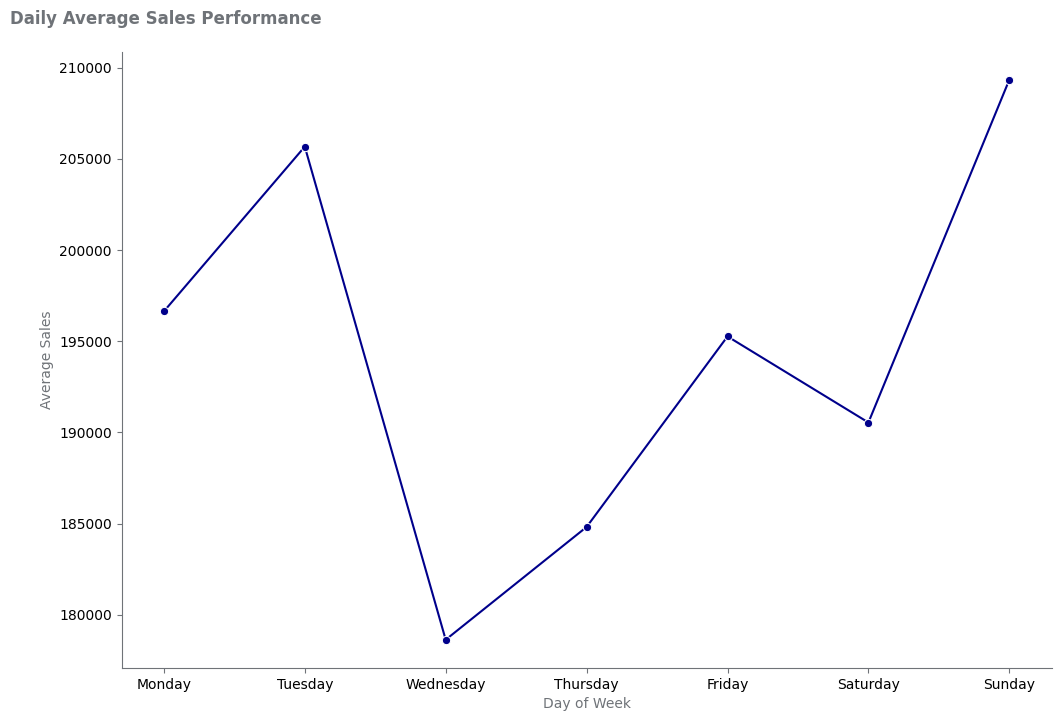

In [46]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(12,8))

# Plot the daily sales performance
sns.lineplot(x='Day', y='Revenue', data=df, ci=None, color='darkblue',
             marker='o', ax=ax)

# Despine the right side
sns.despine(right=True)

ax.set_xlabel('Day of Week', color='#6F7378')
ax.set_ylabel('Average Sales', color='#6F7378')

for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Daily Average Sales Performance', pad=20, x=-0.12,
             weight='bold', color='#6F7378', ha='left')
ax.tick_params(color='#6F7378')

plt.show()

When plotting the daily average sales, it can be seen that there is a notable uptrend in the end of the week, with sales peaking on Sunday. In contrast, customer tends to buy less during the midweek from Tuesday to Wednesday. This might be due to the fact that majority of the customers having less leisure time to go shopping.

### **Into the Cities**

To gain an overview of the sales patterns across different cities, we should examine the asles distribution by cities. First, we will aggregate the total `Revenue` by each city in this dataset and use a cloroplhet map to see the overall distribution of sales accross the cities in the US.

In [ ]:
# Change `City` to be a simple pandas series. So, as a string
df['City'] = df['City'].astype(str)

# Use geocoding API to get the latitude and longitude of each city
geolocator = Nominatim(user_agent="city_geocoder")

def get_lat_long(city):
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            return(location.latitude, location.longitude)
        else:
            return(None, None)
    except GeocoderTimedOut:
        return get_lat_long(city) # Retry on timeout

df['Coordinates'] = df['City'].apply(get_lat_long)
df[['Latitude', 'Longitude']] = pd.DataFrame(df['Coordinates'].tolist(), index=df.index)

# Check for Missing Coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Aggregate the data by city
df_aggregated = df.groupby('City').agg({
    'Revenue': 'sum',
    'Latitude': 'first',
    'Longitude': 'first'
}).reset_index()

# Create a map centered around the USA
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(m)

# Add city markers
for idx, row in df.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                        radius=10,
                        popup=f"{row['City']}: ${row['Revenue']}",
                        color='blue',
                        fill=True,
                        fill_color='blue').add_to(marker_cluster)
    
m.save('us_sales_cloropleth.html')

The code above generated an interactive [Cloropleth Map](https://github.com/lazuardifp19/lazuardfp_portfolio/blob/main/Ecommerce%20Analysis%20K%20Means/us_sales_cloropleth.html) of the sales.

*Note: as GitHub cannot render it, downloading the cloropleth is advised for a smooth operations and analysis*

Based on the observation, we can infer the following:
1. The Top 3 highest revenue by State are New York, California, and Texas.
2. The top 3 highest revenue by City are New York City, San Francisco, and Conecticut.
4. It was assumed that the customer base was only from the US as seen from distribution graph of transactions by the cities. The chloropleth map reveals that there are transactions from outside of the US.
5. The top cities outside the US are: Columbia, Birmingham, San Juan, and Toledo, ranked from the highest to the lowest, respectively.

This trend suggest that the main market for this e-commerce is in a high-density population region where people are more tech-savvy.

### **Products**

First, we should determine the number of products this e-commerce store offers to its customers.

In [47]:
print(f"Total Product: {df['ProductName'].nunique()}")

Total Product: 100


It is identified that this e-commerce has a relatively low numbers of variety with 100 items. To identify the most influential products driving the sales, we will analyze the top 10 contributors to overall revenue.

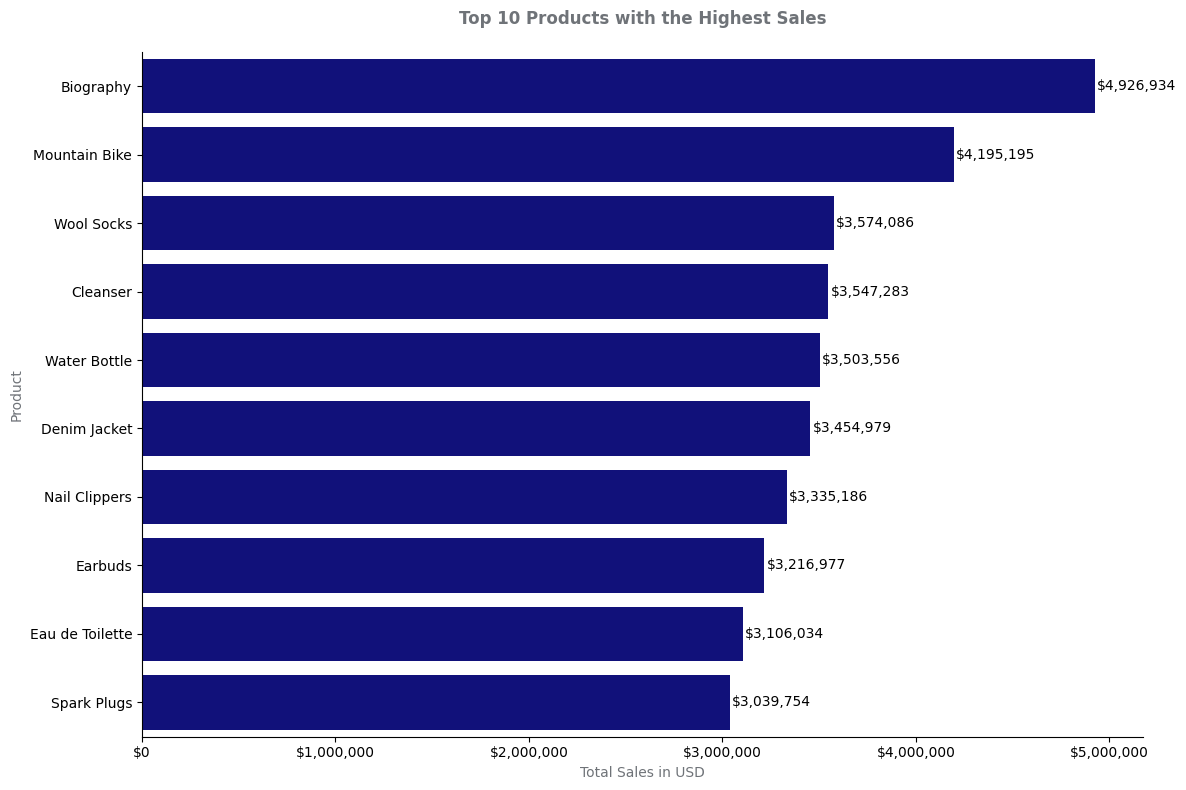

In [48]:
# Get the total sales by product
product_sales = df.groupby('ProductName', as_index=False)['Revenue'].sum()

# Sort the products by Revenue in descending order and get the top 10
top_10_product_sales = product_sales.sort_values('Revenue', ascending=False).head(10)

# Set the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the top 10 products with the highest sales
sns.barplot(x='Revenue', y='ProductName',
            data=top_10_product_sales, order=top_10_product_sales['ProductName'],
            color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='${:,.0f}', padding=1.5)

# Set the label of axes
ax.set_xlabel('Total Sales in USD', color='#6F7378')
ax.set_ylabel('Product', color='#6F7378')

# Format x-axis labels to show in x00,000 format
formatter = ticker.FuncFormatter(lambda x, pos: f"${int(x):,}")
ax.xaxis.set_major_formatter(formatter)

# Set the title
ax.set_title('Top 10 Products with the Highest Sales', pad=20, weight='bold', color='#6F7378')

plt.tight_layout()
plt.show()

The top 10 product with the highest total revenue represent a diverse mix of household goods, clothing, hobbies, and gadget, with Biography being the top-selling product in the last 12 months.

After examining the top 10 products by total revenue, we focus on the top 10 products with the highest median order quantities to uncover any underlying trends in customer purchasing behavior.

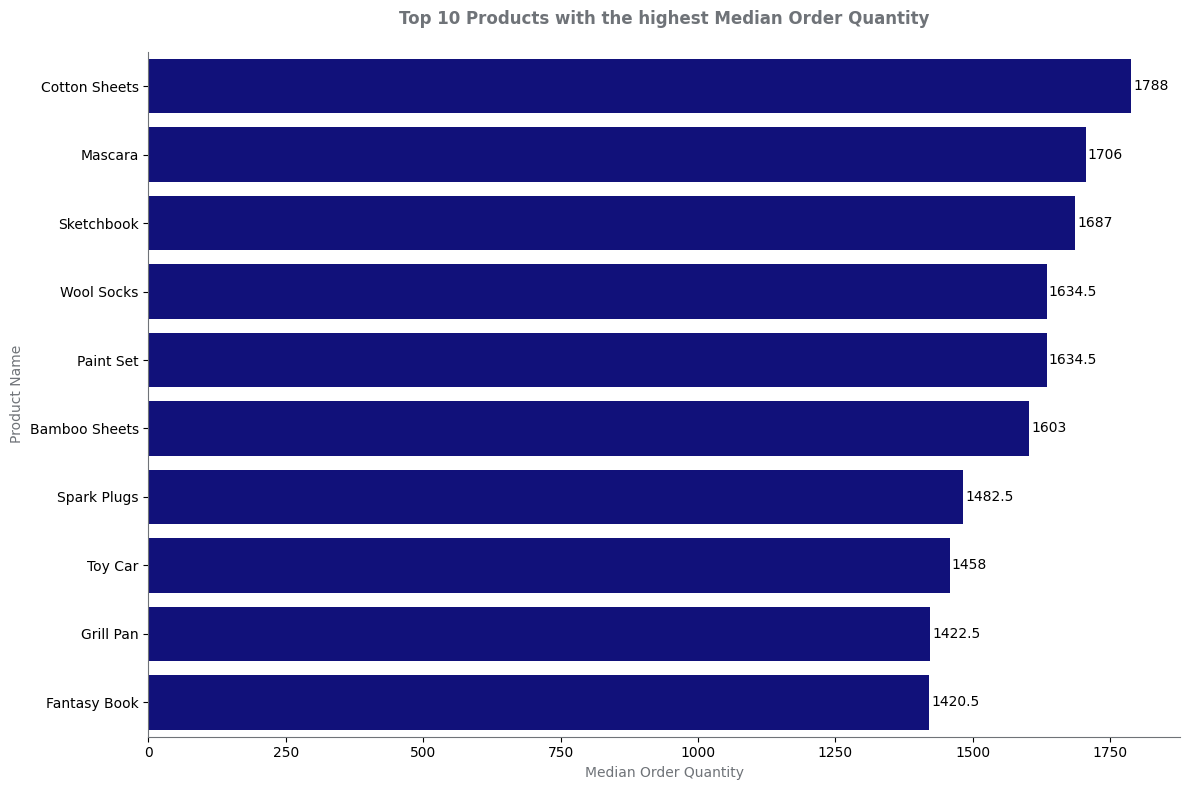

In [49]:
# Get the median quantity of the products
product_quantity = df.groupby('ProductName', as_index=False)['Sales'].median()
product_quantity.columns = ['ProductName', 'MedianOrderQuantity']

# Sort the product by Quantity in descending order and get the top 10
top10_product_quantity = product_quantity.sort_values('MedianOrderQuantity', ascending=False).head(10)

# Set the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the top 10 products with highest mean quantity
sns.barplot(x='MedianOrderQuantity', y='ProductName',
              data=top10_product_quantity, order=top10_product_quantity['ProductName'],
              color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Add bar labels
ax.bar_label(ax.containers[0], padding=1.5)

# Set the x and y axis label
ax.set_xlabel('Median Order Quantity', color='#6F7378')
ax.set_ylabel('Product Name', color='#6F7378')

# Change spine color
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Top 10 Products with the highest Median Order Quantity', pad=20, weight='bold', color='#6F7378')

plt.tight_layout()
plt.show()

The top 10 products with the highest median order quantity reflects a steady demand for these products. Other insights includes:
1. Products like **Cotton Sheets**, **Mascara**, and **Sketchbook** indicate popular categories among customers, suggesting a potential high demand in these products.
2. Products such as **Paint Set** and **Fantasy Book** might appeal to a specific consumer demographics interested in hobbies or leisure activites.
3. **Cotton Sheets**, **Mascara**, **Sketchbook**, **Wool Socks**, **Paint Set**, and **Bamboo Sheets** with significant median order quantites may require careful inventory management to ensure availability and meet customer demand consistently.

## **3.4 Product-centric RFM Analysis with K-Meanss**
RFM (Recency, Frequency, Monetary) analysis is a powerful method for segmentation an we are going to employ that in this analysis. Instead of focusing on individual customers, this RFM analysis would be a product-centric RFM analysis as the dataset does not have any identifier for customer.

First, we are going to calculate Recency, Frequency, and Monetary metrics for each product by:
1. `Recency`: Determine the recency by substracting the `Date` from the analysis date, assuming the analysis is conducted one day after the latest recorded transaction date.
2. `Frequency`: For each product, we'll calculate the frequency metric by counting the number of sales in the `Sales` column, which indicates the total number of distinct transactions made.
3. `Monetary`: Aggregate how much each product made from the `Revenue` column.



In [50]:
# Calculate the most recent date in the dataset
latest_date = df['DateAdded'].max()

# Calculate Recency, Frequency, and Monetary values for each product
rfm_product = df.groupby('ProductName').agg({
    'DateAdded': lambda x: (latest_date - x.max()).days, # Recency
    'Sales': 'sum', # Frequency
    'Revenue': 'sum' # Monetary
}).rename(columns={'DateAdded': 'Recency', 
                   'Sales': 'Frequency',
                    'Revenue': 'Monetary'})

rfm_product

,Recency,Frequency,Monetary
ProductName,,,
Action Figure,28,8589,1.240311e+06
Ankle Socks,12,11447,2.168213e+06
Art Print,49,7648,9.261804e+05
Bamboo Sheets,43,10277,2.179639e+06
Bath Salts,6,11471,1.678966e+06
...,...,...,...
Weighted Blanket,71,10245,1.629700e+06
White Wine,86,10092,1.500055e+06
Wine Glass,16,8616,1.477578e+06


We segmented the products based on the Recency, Frequency, and Monetary and identified that there are a total of 100 products.

### RFM Data: Exploration

Before preprocessing the variables in the RFM data, we should explore the vairables to identify outliers, skewness, and central tendencies for each variables.

In [51]:
rfm_product.describe(exclude='object').round(2)

,Recency,Frequency,Monetary
count,100.00,100.00,100.00
mean,34.57,10110.37,1942325.77
std,43.41,3490.31,820213.59
min,0.00,2807.00,554037.73
25%,7.75,7395.00,1378355.58
50%,18.00,9828.50,1817166.85
75%,44.25,12495.50,2393842.37
max,244.00,23947.00,4926934.01


Based on the descriptive statistics, we can infer the following:
1. **Outliers**: Across all RFM variables shows outliers with the values of 244, 23,947, and $4,926,934 respectively. These outliers should be identified further using boxplots.
2. **Data Dispersion**: The `Recency` and `Frequency` shows that the standard deviations exceeds the mean, indicating a wider spread of data points around the average value, suggesting that the data is more dispersed and less concentrated. However, for `Monetary`, the standard deviation is less than the mean, which suggest that the data is more concentrated.
3. **Skewness**: Positive-skewness is identified all across the RFM variables as the mean is higher than the median value.

Next, we should investigate the distribution further using boxplots.

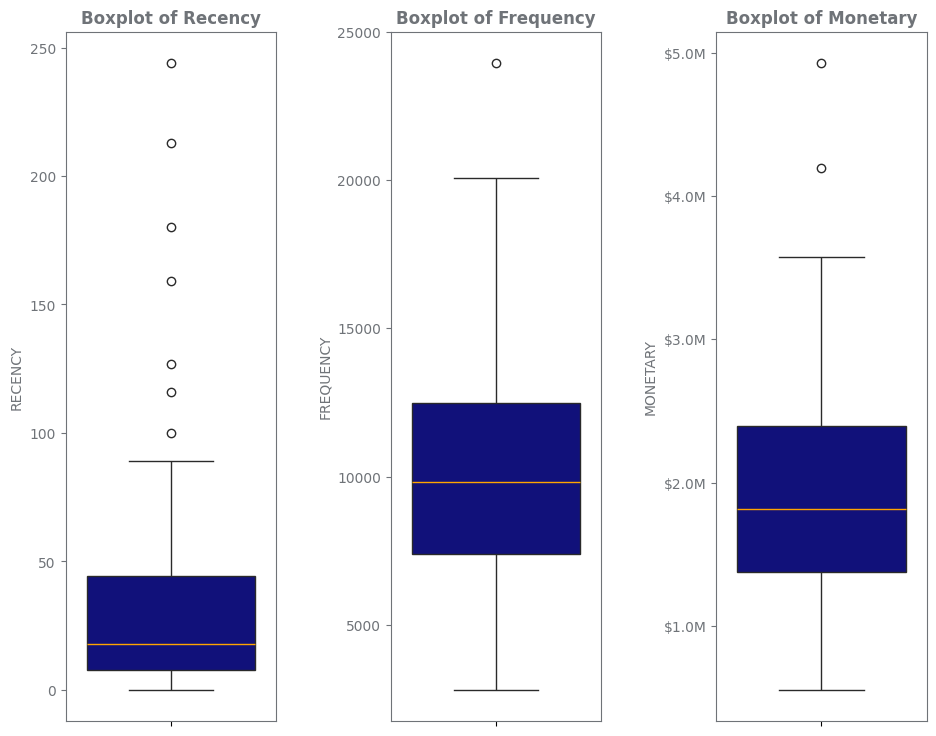

In [52]:
# Custom formatter for monetary values
def monetary_formatter(x, pos):
    return f'${x*1e-6:.1f}M'

# Set the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(10,8))

# List of RFM variables
rfm_vars = rfm_product.columns

# Create the box plot
for i, var in enumerate(rfm_vars):
    sns.boxplot(y=rfm_product[var], color='darkblue',
                medianprops={'color':'orange'}, ax=ax[i])
    
    ax[i].set_ylabel(var.upper(), color='#6F7378')
    ax[i].tick_params(axis='y', colors='#6f7378')
    
    # Change the spine color
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

    ax[i].set_title(f'Boxplot of {var}', weight='bold', color='#6F7378')

    if var == 'Monetary':
        ax[i].yaxis.set_major_formatter(FuncFormatter(monetary_formatter))

plt.tight_layout(pad=3)
plt.show()

It can be seen from the boxplot that:
- **Recency**: `Recency` has a relatively more positive-skewness compared to the other RFM variabels. Moreover, it shows many outliers with several extreme outliers. These outliers might significantly impact the overall data pattern.
- **Frequency and Monetary**: Both `Frequency` and `Monetary` variables shows a slight positive-skewness compared to `Recency`. Moreover, outliers exists in both variables, but the amount of variables are less than `Recency`.

To further confirm the distribution shapes and skewness of RFM variables, we should explore further using histogram and skewness measures.

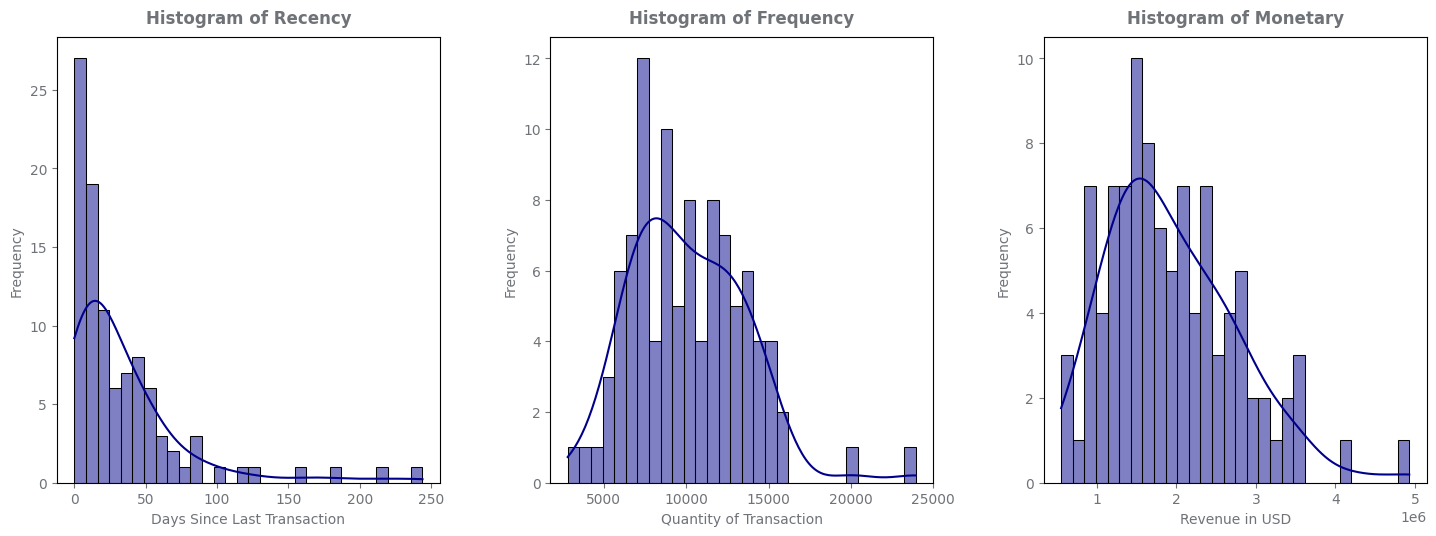

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(15,6))

for i, var in enumerate(rfm_product):
    
    if var == 'Recency':
        sns.histplot(x=var, data=rfm_product, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Days Since Last Transaction', color='#6F7378')
    
    elif var == 'Frequency':
        sns.histplot(x=var, data=rfm_product, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Quantity of Transaction', color='#6F7378')
    
    else:
        sns.histplot(x=var, data=rfm_product, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Revenue in USD', color='#6F7378')

    ax[i].set_ylabel('Frequency', color='#6F7378')
    ax[i].tick_params(axis='both', colors='#6F7378')
    ax[i].set_title(f'Histogram of {var}', weight='bold', color='#6F7378', pad=10)

plt.tight_layout(pad=3.0)
plt.show()

In [54]:
print(f'Skewness measurements: \n{rfm_product.skew(numeric_only=True)}')

Skewness measurements: 
Recency      2.668042
Frequency    0.765299
Monetary     0.850642
dtype: float64


It can be seen from the graph that our initial assumptions that the distributions are positively-skewed across all the RFM variables, with `Recency` having a relatively higher skewness than the other two. Global outliers is likely to be the main contributor to this high skewness.

### **Handling the Outliers**

To be able to achieve a high degree of accuracy using the K-means clustering algorithm, we need to address the presenec of the outliers as they would be highly influencing the clustering result. THis process will identify and remove or adjusting the outliers to minimize their impact on the clustering.

We are going to use the IQR method to handle the outliers.

In [55]:
rfm_dirty = len(rfm_product)
print(f'Rows before outlier handling (z-score)L {rfm_dirty}')

# Create the filter mask
entry_filter = np.array([True] * len(rfm_product))


# IQR filtering
for i in rfm_vars:
    rfm_Q1 = rfm_product[i].quantile(0.25)
    rfm_Q3 = rfm_product[i].quantile(0.75)
    rfm_IQR = rfm_Q3 - rfm_Q1
    rfm_low_limit = rfm_Q1 - (1.5 * rfm_IQR)
    rfm_upper_limit = rfm_Q3 + (1.5 * rfm_IQR)
    entry_filter = ((rfm_product[i] >= rfm_low_limit) & (rfm_product[i] <= rfm_upper_limit)) & entry_filter

rfm_product = rfm_product[entry_filter]

# Get and check the total rows after outlier handling
rfm_cleaned = len(rfm_product)
print(f'Rows before outlier handling (z-score): {len(rfm_product)}')
print(f'Data loss: {round((rfm_dirty - rfm_cleaned) / rfm_cleaned * 100, 2)}%')

Rows before outlier handling (z-score)L 100
Rows before outlier handling (z-score): 91
Data loss: 9.89%


We experienced a data loss of approximately 9.89% in the outlier removal using IQR method.
Now we should continue to visualize the distribution of the cleaned rfm data to assess the effectiveness of the outlier handling.

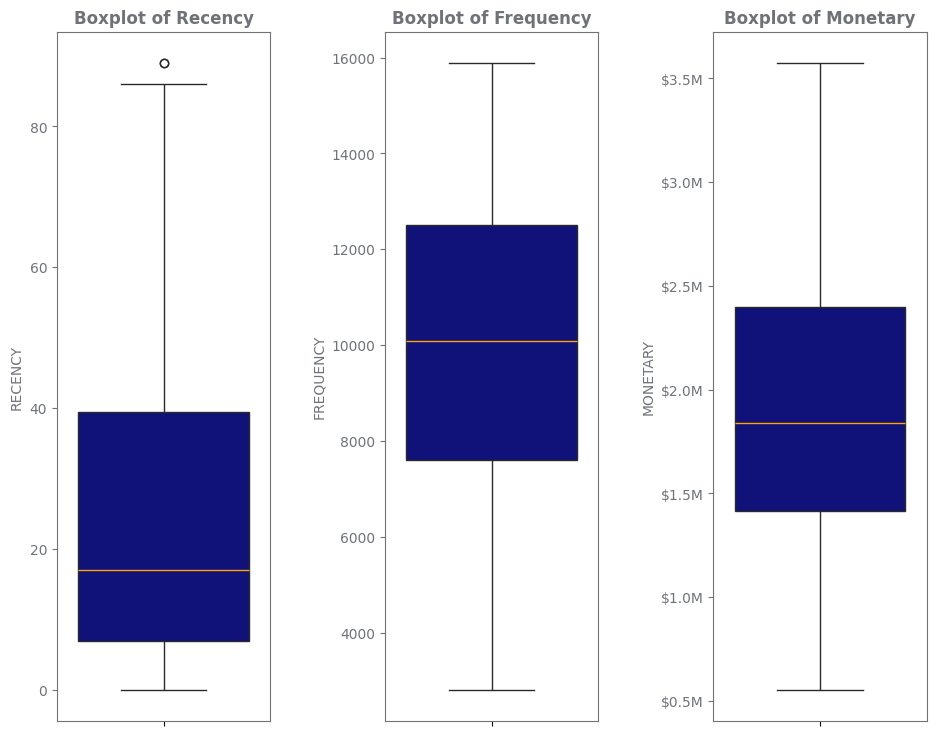

In [56]:
# Custom formatter for monetary values
def monetary_formatter(x, pos):
    return f'${x*1e-6:.1f}M'

# Set the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(10,8))

# List of RFM variables
rfm_vars = rfm_product.columns

# Create the box plot
for i, var in enumerate(rfm_vars):
    sns.boxplot(y=rfm_product[var], color='darkblue',
                medianprops={'color':'orange'}, ax=ax[i])
    
    ax[i].set_ylabel(var.upper(), color='#6F7378')
    ax[i].tick_params(axis='y', colors='#6f7378')
    
    # Change the spine color
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

    ax[i].set_title(f'Boxplot of {var}', weight='bold', color='#6F7378')

    if var == 'Monetary':
        ax[i].yaxis.set_major_formatter(FuncFormatter(monetary_formatter))

plt.tight_layout(pad=3)
plt.show()

After the outlier cleaning with IQR method, the RFM variables distribution are cleaner and better represent the central tendency of the data. However, there are still one outlier remains in the `Recency` due to the moderate values and a reflection of the diverse purchasing behavior of customers. Despite identified as an outlier, it is still a valid transaction.

### **Scaling**

Data scaling is vital to ensure accurate and meaningful clustering results which work by normalizing the data, preventing variables with more extensive ranges, such as `Recency` in this case, from excessively influencing the distance calculations.

In [57]:
# Initialize the scaler
scaler = StandardScaler().set_output(transform='pandas')

# Scale the data
rfm_scaled = scaler.fit_transform(rfm_product)

print(rfm_scaled.head())

                Recency  Frequency  Monetary
ProductName                                 
Action Figure  0.128603  -0.530141 -0.961397
Ankle Socks   -0.583358   0.439950  0.318474
Art Print      1.063051  -0.849545 -1.394683
Bamboo Sheets  0.796066   0.042817  0.334234
Bath Salts    -0.850343   0.448096 -0.356353


### **Principal Component Analysis (PCA)**

We should apply PCA with the goal to enhance the K-Means performance by reducing the redundancy and focus on the informative variables. This minimizes the impact of multicolinearity, especially in the RFM variables. Moreover, it facilitates cluster visuaization with 2D scatter plots instead of 3D, which simplify cluster understanding.

In [58]:
# Initialize the PCA object
pca = PCA(n_components=2)

# Fit the PCA to the scaled RFM dataset
pca.fit(rfm_scaled)

# Transform the scaled RFM dataset to PCA
pca_df = pd.DataFrame(pca.transform(rfm_scaled), columns=['PC1', 'PC2'])
pca_df.set_index(rfm_scaled.index, inplace=True)

pca_df

,PC1,PC2
ProductName,,
Action Figure,-1.038556,-0.229179
Ankle Socks,0.694943,-0.385165
Art Print,-1.840591,0.481727
Bamboo Sheets,-0.002688,0.848342
Bath Salts,0.336539,-0.811147
...,...,...
Water Bottle,2.614653,0.058764
Weighted Blanket,-0.912371,1.829089
White Wine,-1.279391,2.404581


### **K-Means Clustering**
As the original values of each RFM variables has been scaled. Now, we can proceed to perform K-means clustering. But, before that, we need to examine the Sum of Squared Errors (SSE), and the silhouette coefficient for values of 'k' ranging from 2 to 10.

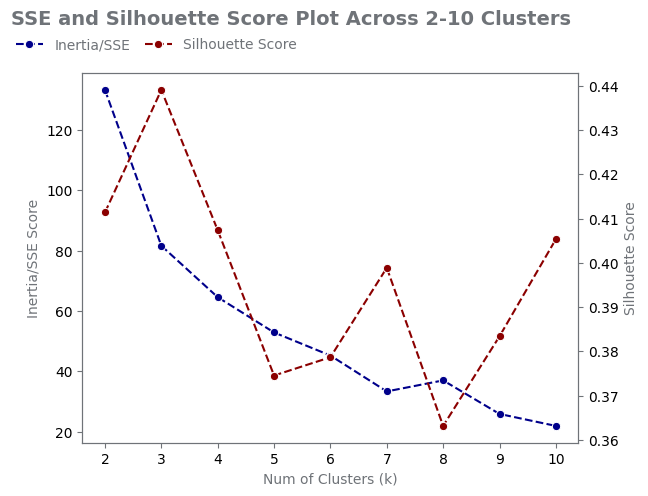

In [59]:
# Define empty variables to be filled with SSE and Silhoutte scores
sse = []
silhouette = []

# Get the SSE and Silhouette Scores
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state=42).fit(pca_df)
    sse.append(kmeans.inertia_)
    cluster_label = kmeans.labels_
    silhouette.append(silhouette_score(pca_df, cluster_label))

# Plot of SSE and Silhouette metrics
fig, ax = plt.subplots()
sns.lineplot(x=range(2, 11), y=sse, marker='o', linestyle='--', color='darkblue',
             label='Inertia/SSE', ax=ax)

ax2 = ax.twinx()

# Plot for the Silhouette Score
sns.lineplot(x=range(2,11), y=silhouette, marker='o', linestyle='--', color='darkred',
             label='Silhouette Score', ax=ax2)

# Set x and y label
ax.set_xlabel('Num of Clusters (k)', color='#6F7378')
ax.set_ylabel('Inertia/SSE Score', color='#6F7378')
ax2.set_ylabel('Silhouette Score', color='#6F7378')

# Add legends
ax.legend(loc=2, frameon=False, bbox_to_anchor=[-0.16, 1.13], labelcolor='#6F7378')
ax2.legend(loc=2, frameon=False, bbox_to_anchor=[0.1, 1.13], labelcolor='#6F7378')

# Set title
ax2.set_title('SSE and Silhouette Score Plot Across 2-10 Clusters', weight='bold', size=14,
              pad=35, x=0.42, color='#6F7378')

# Change tick color
ax.tick_params(color='#6F7378')
ax2.tick_params(color='#6F7378')

# Change spine color
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')
for spine in ax2.spines.values():
    spine.set_edgecolor('#6F7378')

plt.show()

It can be seen that the highest silhouette score is 3 and is located at the 'elbow' part of the SSE lineplot. It can be said that the optimal value for k is 3. However, we should check further using the silhouette plot.

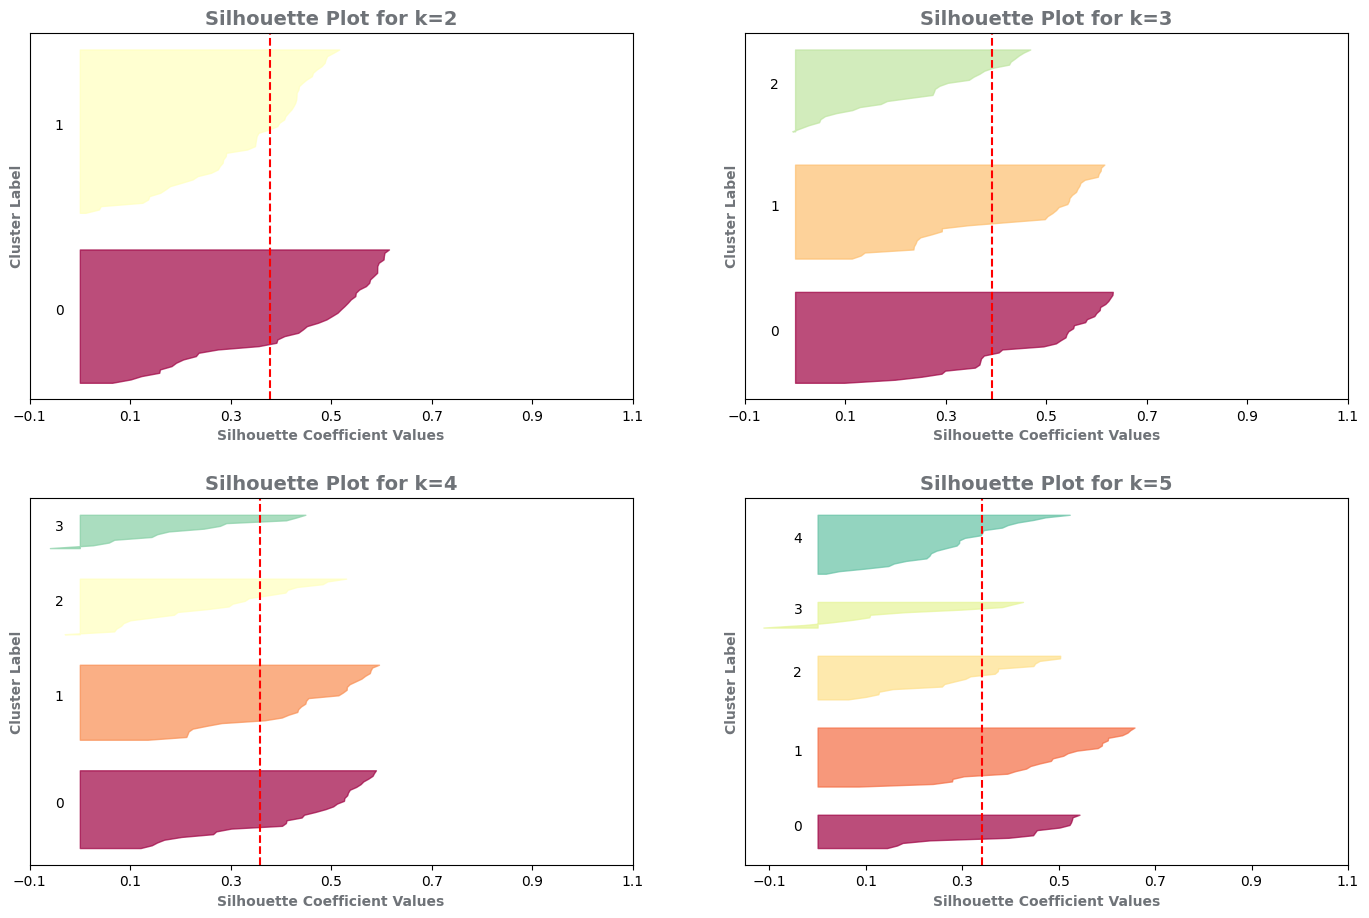

In [60]:
# Function to plot silhouette
def plot_silhouette(data, n_clusters):
    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    fig.tight_layout(pad=5.0)

    for k in range(2, n_clusters + 1):
        km = KMeans(n_clusters=k, random_state=42)
        cluster_label = km.fit_predict(data)

        silhouette_avg = silhouette_score(data, cluster_label)
        silhouette_sample_val = silhouette_samples(data, cluster_label)

        ax_idx = k - 2
        row, col = divmod(ax_idx, 2)

        y_lower = 10
        for i in range(k):
            ith_cluster_silhouette_values = silhouette_sample_val[cluster_label == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.Spectral(float(i)/k)
            ax[row][col].fill_betweenx(np.arange(y_lower, y_upper),
                                       0, ith_cluster_silhouette_values,
                                       facecolor=color, edgecolor=color, alpha=0.7)
            ax[row][col].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10
        
        ax[row][col].set_title(f'Silhouette Plot for k={k}', weight='bold', fontsize=14, color='#6F7378')
        ax[row][col].set_xlabel('Silhouette Coefficient Values', weight='bold', color='#6F7378')
        ax[row][col].set_ylabel('Cluster Label', weight='bold', color='#6F7378')

        ax[row][col].axvline(x=silhouette_avg, color='red', linestyle='--')
        ax[row][col].set_yticks([])
        ax[row][col].set_xticks(np.arange(-0.1, 1.1, 0.2))
    
    plt.show()

# Plot silhouette for clusters 2 to 5 
plot_silhouette(rfm_scaled, 5)
        

Based on the silhouette plot, it can be concluded that k=3 is the most appropriate number for this dataset since the silhouette plot for k=3 shows the highest silhouette score. As k increases beyond 3, the average silhouette score decreases, and the presence of negative scores become more frequent, indicating that higher values of k result in clusters that are note well-separated.

Therefore, let us apply `k` equals 3 in the clustering process and get the cluster labels.

In [61]:
# Initialize the K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_df)

# Assign the cluster label to the PCA data to be visualized
pca_df['Cluster'] = kmeans.labels_

Now, we should visualize using the pairplots for the RFM variables to visualize the clustering.

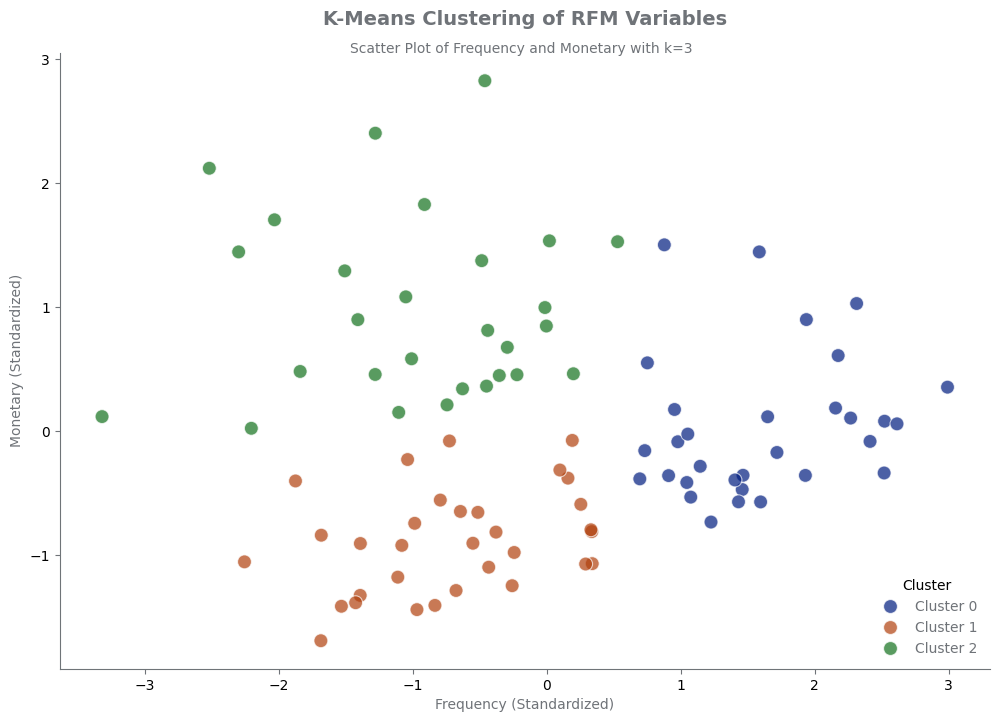

In [62]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Use scatter plot to see the formed clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df,
                palette='dark', ax=ax, s=100, alpha=0.7)

# Despine the right side
sns.despine(right=True)

# Change tick color
ax.tick_params(color='#6F7378')

# Set the x and y axis label
ax.set_xlabel('Frequency (Standardized)', color='#6F7378')
ax.set_ylabel('Monetary (Standardized)', color='#6F7378')

# Change the spine color
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7478')

# Set title
ax.set_title('K-Means Clustering of RFM Variables', weight='bold', size=14, x=0.5, pad=20, color='#6F7378')
ax.text(0.68, 1, 'Scatter Plot of Frequency and Monetary with k=3', transform=ax.transAxes, ha='right', color='#6F7378')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Cluster ' + str(i) for i in range (3)], title='Cluster',
          loc='lower right', frameon=False, labelcolor='#6F7378')

plt.show()

From the scatter plot, it is observed an acceptable separation between the clusters. Moreover, the overall shapes indicates that our clustering process has yielded great clusters.

Next, we should compare the RFM statistical summaries of the identified clusters. Considering the skewed distribution of the initial data, we'll choose the median over the mean as the measure of central tendency across the RFM variable. We should also assign the cluster column produced from the PCA data to the original RFM data.

In [63]:
# Assign produced clusters fromt the PCA data to the original RFM data
rfm_product['Cluster'] = pca_df['Cluster']

# Group the cluster and aggregating the min, max, and median of RFM variables
rfm_product.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max']
})

Recency                    Frequency                        \
              mean median min max          mean   median   min    max   
Cluster                                                                 
0        14.161290   10.0   0  51  13258.290323  13411.0  9862  15886   
1        11.406250   10.5   0  30   8416.781250   8381.5  5375  12362   
2        52.892857   48.0  34  89   8692.285714   8966.5  2807  12393   

             Monetary                                            
                 mean        median           min           max  
Cluster                                                          
0        2.735699e+06  2.734602e+06  1.986065e+06  3.574086e+06  
1        1.392641e+06  1.405130e+06  5.766579e+05  2.378510e+06  
2        1.675894e+06  1.651225e+06  5.540377e+05  2.541248e+06

Based on the summary statistics provided we can label each cluster to reflect their distinguishing characteristics.
- Cluster 0: **Top Performers** (Moderate R, High F, High M)
- Cluster 1: **Low Performers** (Moderate R, Moderate F, Moderate M)
- Cluster 2: **Niche Products** (High R, Moderate F, Moderate M)

To compare the cluster groups easier, we should create a visualization showing each cluster's distributions and central tendencies of `Recency`, `Frequency`, `Monetary`. We should start with the boxplot to see the distribution of each variable first based on clusters.



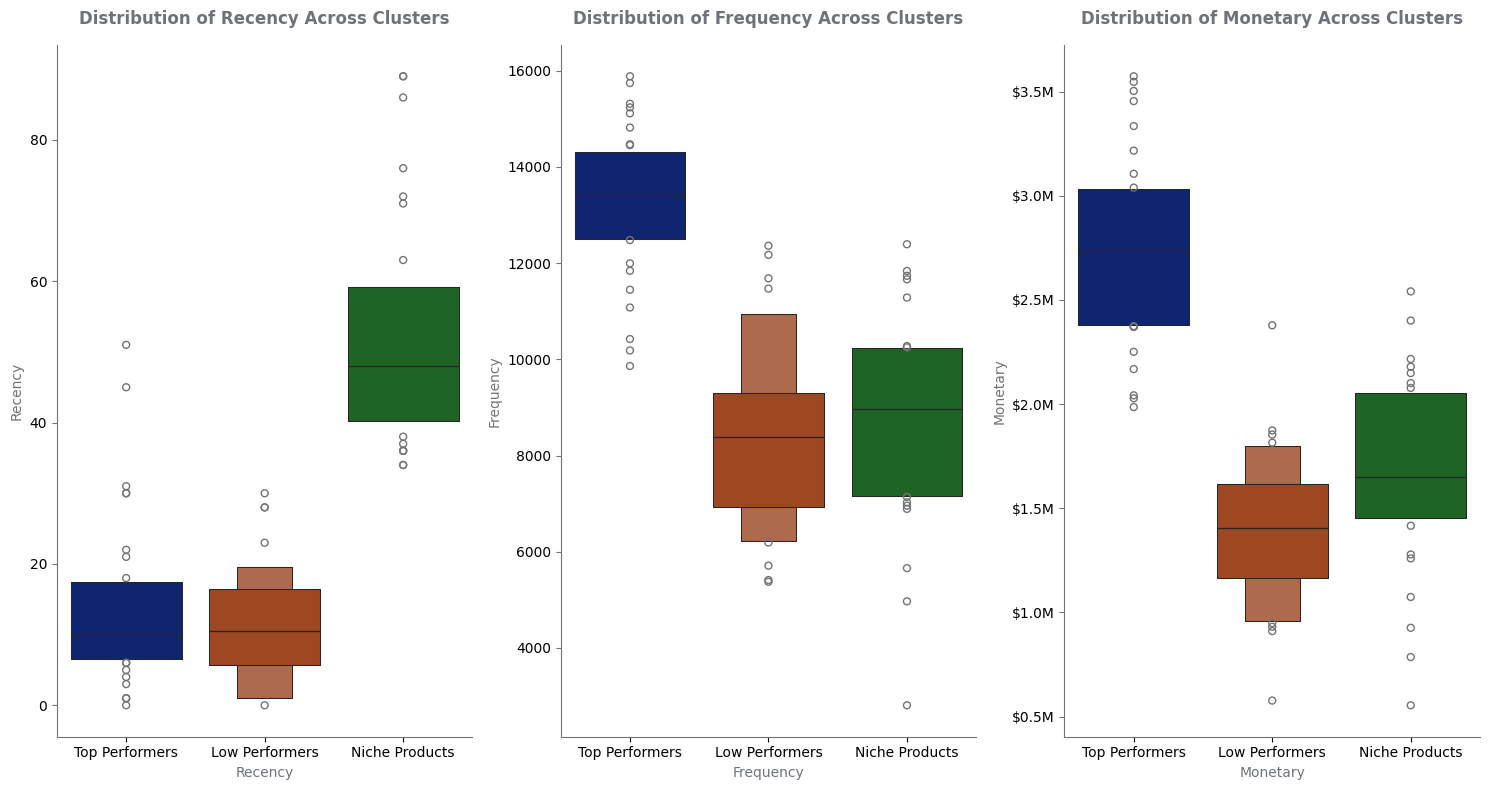

In [64]:
# Add clustername
cluster_map = {0: 'Top Performers',
               1: 'Low Performers',
               2: 'Niche Products'}

# Create variable named ClusterName that contains the name of each cluster
rfm_product['ClusterName'] = rfm_product['Cluster'].map(cluster_map)

rfm_vars = ['Recency', 'Frequency', 'Monetary']

# Define the order for the box plots
cluster_order = ['Top Performers', 'Low Performers', 'Niche Products']

# Box plot for each cluster that compares the median across all RFM variables
fig, ax = plt.subplots(1, 3, figsize=(15, 8))

for i, var in enumerate(rfm_vars):
    sns.boxenplot(x='ClusterName', y=var, data=rfm_product, order=cluster_order,
                   palette='dark', ax=ax[i])

    sns.despine(right=True)

    ax[i].set_ylabel(var, color='#6F7378')
    ax[i].set_xlabel(var, color='#6F7378')

    ax[i].set_title(f'Distribution of {var} Across Clusters', weight='bold', pad=15, color='#6F7378')

    if var == 'Monetary':
        ax[i].yaxis.set_major_formatter(FuncFormatter(monetary_formatter))

    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

    ax[i].tick_params(axis='y', color='#6F7378')

    # Rotate x-axis label
    plt.setp(ax[i].get_xticklabels(), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

Then, we should use barplot to see the central tendency across all RFM variables, using median as our estimator.

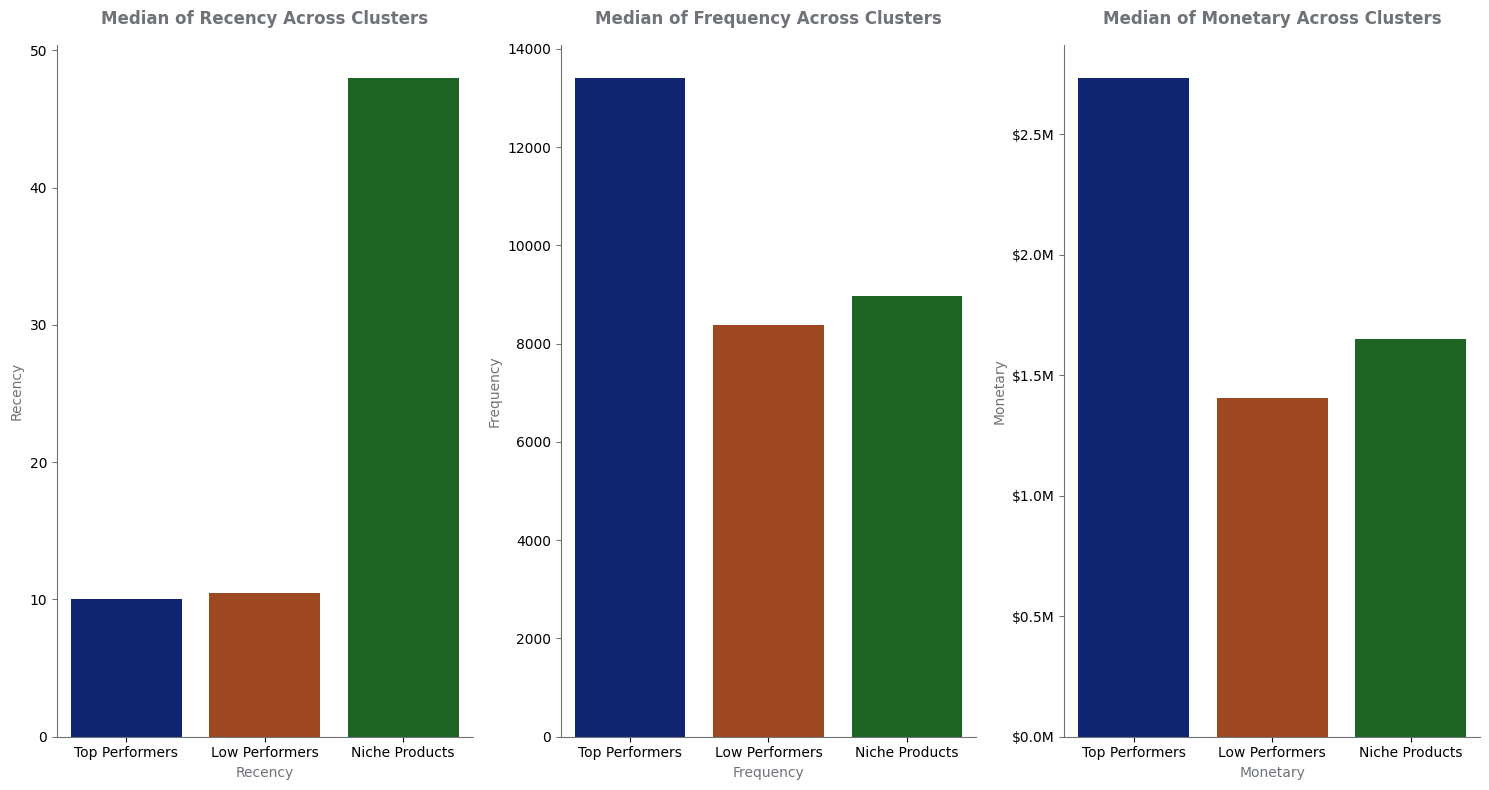

In [65]:
# Set the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 8))

for i , var in enumerate(rfm_vars):
    sns.barplot(x='ClusterName', y=var, data=rfm_product, order=cluster_order,
                 estimator='median', ci=None, palette='dark', ax=ax[i])
    
    sns.despine(right=True)

    ax[i].set_ylabel(var, color='#6F7378')
    ax[i].set_xlabel(var, color='#6F7378')

    ax[i].set_title(f'Median of {var} Across Clusters', weight='bold', pad=15, color='#6F7378')

    if var == 'Monetary':
        ax[i].yaxis.set_major_formatter(FuncFormatter(monetary_formatter))

    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
        
    ax[i].tick_params(axis='y', color='#6F7378')

    plt.setp(ax[i].get_xticklabels(), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

From these bar and box plots, we can identify each cluster's characteristics:
1. **Top Performers (Blue)**
    - Low Recency:
        - Products in this cluster are sold quite recently with the median of around 10 days.
        - This cluster shows a tight range with a few outliers, suggesting that these products are consistently sold frequently.
    - High Frequency:
        - Products in this cluster has the highest median Frequency with median of approximately 13,000 units sold.
        - The cluster shows a high frequency range, indicating that these products are in constant demand.
    - Highest Monetary:
        - The median Monetary value for this cluster is the highest, indicating these products generate the most revenue.
        - The cluster shows that this products consistently bring high revenue, with some outliers contributing even more.
2. **Low Performers (Orange)**
    - Low Recency:
        - The median Recency for this cluster is slightly higher than the Top Performers at around 11 days, but still relatively low when compared to the Niche Products.
        - Products in this cluster are sold regularly but not as recently as the Top Performers.
        - This cluster shows a wider range of recency with more outliers, suggesting some variability in sales frequency.
    - Lowest Frequency:
        - The median Frequency for products in this cluster is the lowest when compared to the other cluster. However, the value is not far lower than the Niche Products.
        - Products in this cluster are sold regularly but not as often.
        - This cluster shows a wider range, which indicates that some products are sold more frequently than others within this cluster.
    - Lowest Monetary:
        - The median Monetary value for this cluster is the lowest among all clusters.
        - Products in this cluster generate the least revenue.
        - The Monetary distribution shows a lower revenue range, with some outliers indicating occasional products generating higher revenue.
3. **Niche Products (Green)**
    - Highest Recency:
        - The median Recency for this cluster is the highest with approximately 48 days.
        - These products have not been sold recently.
        - The distribution shows a wide range of recency, with mny outliers, suggesting that products in this cluster are sold infrequently.
    - Moderate Frequency:
        - The median frequency for this cluster is around 8,400 transactions.
        - The performance of this cluster is between the Top Performers and Low Performers.
        - Products in this cluster shows a moderate range with some variability, suggesting that these products have a niche but consistent market.
    - Moderate Monetary:
        - The median Monetary for this cluster is around 8,600 transactions.
        - Products in this cluster generate moderate revenue, more than the Low Performers.
        - The Monetary distribution shows a moderate revenue range, with some outliers indicating occasional higher revenue products.

Based on the clusters' characteristics we have outlined, we now can analyze behavioral characteristics of each clusters, which will help develop targeted marketing strategies.


### Demographic Characteristics
We should identify the distribution of each product cluster across different cities. This will help understand which product cluster in certain locations.

Firstly, we should create a unique identifier for rfm_products as it does not have and we are unabe to merge the rfm_product and df.

In [113]:
# Create unique identifier for rfm_products
rfm_product_indexed = rfm_product.reset_index().rename(columns={'index': 'RFM_ID'})
rfm_product_indexed['RFM_ID'] = range(len(rfm_product_indexed))

# Merge based on this new RFM_ID
df['temp_id'] = range(len(df))
df_clusters = df.merge(rfm_product_indexed[['RFM_ID', 'ClusterName']], 
                       left_on='temp_id', 
                       right_on='RFM_ID', 
                       how='left')
df_clusters = df_clusters.drop(['temp_id', 'RFM_ID'], axis=1)

print(df_clusters.columns)


Index(['ProductID', 'ProductName', 'Category', 'Price', 'Rating', 'NumReviews',
       'StockQuantity', 'Discount', 'Sales', 'DateAdded', 'City', 'Day',
       'Month', 'Revenue', 'ClusterName'],
      dtype='object')


As we successfully create a unique identifier for rfm_product, we also successfully merged the two dataframes. Now, we are able to visualize the distribution for each category by its cities.

In [ ]:
# Get City by each ClusterName and calculate for its percentage in a new column
city_dist = df_clusters.groupby(['ClusterName', 'City']).size().reset_index(name='Count')
city_dist['Percentage'] = city_dist.groupby('City')['Count'].transform(lambda x: x / x.sum() * 100)

fig, ax = plt.subplots()
sns.barplot(x='City', y='Percentage', hue='ClusterName',
            data=city_dist, palette='dark', ax=ax)
sns.despine(right=True)

ax.set_xlabel('City')
ax.set_ylabel('Percentage of Products')
ax.set_title('Product Cluster Distribution (%) for Top 10 Cities', weight='bold')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Sales Pattern Over Time
We should examine how sales of different product clusters vary by day and month. This might reveeal seasonal trends or popular shopping days based on the product clusters.

In [ ]:
day_cluster = rfm_product.groupby(['ClusterName', 'Day']).size().unstack().fillna(0)
sns.lineplot(x=day_cluster, y='Cluster')